# Emotion Analysis Using ECG and GSR Signals

## Background
This study used the YAAD, which consists of Electrocardiogram (ECG) and Galvanic Skin Response (GSR) measurements designed explicitly for emotion recognition in young adults (Dar et al., 2022). The data was gathered from 25 participants using wearable Shimmer3 ECG and GSR sensors. It consists of three main components: raw physiological data, extracted ECG and GSR features, and self-annotation labels provided by the participants. 
Features will be extracted using 
- Statistical method
- Autoencoder
- Wavelet transform
- Fourier transform

In [ ]:
#!pip install scikit-learn

In [ ]:
#!pip install imbalanced-learn

## Import the libraries 

In [1]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import warnings

In [2]:
# Load the stimulus description directly from Excel
stimulus_desc = pd.read_excel('Stimulus_Description.xlsx')
stimulus_desc.head()

,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


In [3]:
# Load self-annotation multimodal
self_annotation_multimodal = pd.read_excel('Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal['Annotation'] = 'M'
self_annotation_multimodal.rename(columns={'V_Label': 'Valence', 'A_Label': 'Arousal', 'Four_Labels': 'Four_Label'}, inplace=True)
self_annotation_multimodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,Annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [4]:
self_annotation_multimodal['Emotion'].unique()

array(['Happy', 'Sad', 'Surprise', 'Disgust', 'Fear', 'Mixed', 'Anger',
       'Neutral'], dtype=object)

In [5]:
# Column order for the resulting dataframe
cols_ecg = ['Raw Data'] + list(self_annotation_multimodal.columns)
print(cols_ecg)

['Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label', 'Annotation']


In [6]:
arr_shape = 1000
raw_data_arr = []

def form_data_ecg(data_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = self_annotation_multimodal.loc[(self_annotation_multimodal['Session ID'] == int(s)) & 
                             (self_annotation_multimodal['Participant Id'] == int(p)) & 
                             (self_annotation_multimodal['Video ID'] == int(v)) &
                             (self_annotation_multimodal['Annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['Annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

In [7]:
raw_data_arr =  form_data_ecg(data_array = raw_data_arr, annotation = 'M', data_path = "C:/Users/MR EVANS/Desktop/HUMAN EMOTION ANALYSIS/ECG_GSR_Emotions/Raw Data/Multimodal/ECG")

cols_ecg.append('Target Emotion')
raw_dataframe_ecg = pd.DataFrame(raw_data_arr, columns = cols_ecg)
raw_dataframe_ecg.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe_ecg['Familiarity Score'] = raw_dataframe_ecg['Familiarity Score'].fillna('Never watched')
raw_dataframe_ecg = raw_dataframe_ecg.replace(np.nan, '', regex=True)
raw_dataframe_ecg.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


In [8]:
ecg_dataframe = raw_dataframe_ecg.copy()
ecg_dataframe.head(2)

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy


In [2]:
ecg_dataframe['Raw Data']

### Visualised ECG and GSR signals were used to check for anomalies or patterns corresponding to the participant's emotional state

In [10]:
def plot_ecg_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        try:
            plt.plot(y, label='Session {}'.format(row['Session ID']))
            plt.legend()
        except:
            plt.plot(y)
        
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [11]:
def PlotECG(df, participant_id=10, target_emotion='sad'):
    return df[(df['Participant ID']==participant_id)&(df['Target Emotion']==target_emotion)]

<Figure size 432x288 with 0 Axes>

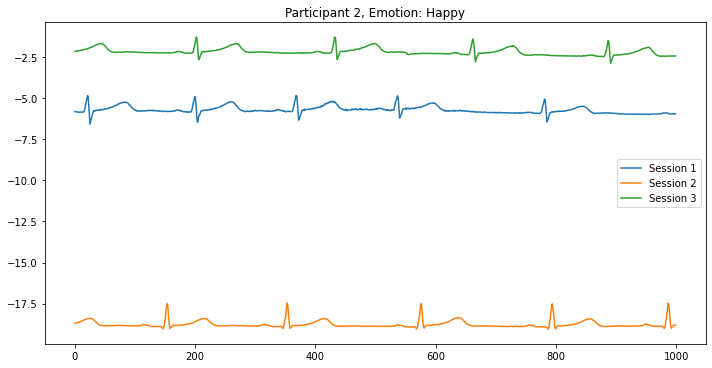

In [12]:
plot_ecg_signals(PlotECG(ecg_dataframe, 2, 'happy'), title='Participant 2, Emotion: Happy')

<Figure size 432x288 with 0 Axes>

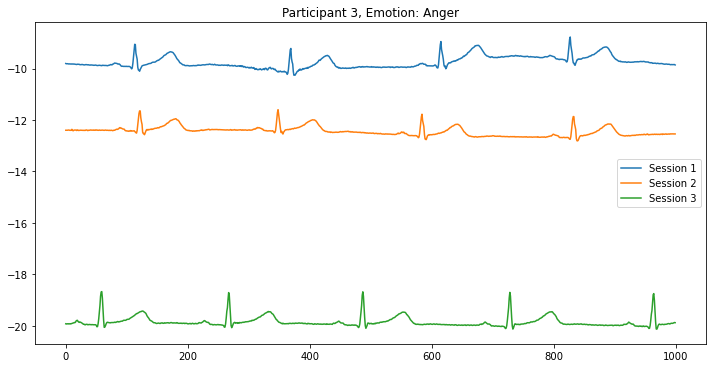

In [13]:
plot_ecg_signals(PlotECG(ecg_dataframe, 3, 'anger'), title='Participant 3, Emotion: Anger')

In [14]:
ecg_dataframe.drop(['Video ID', 'Happy', 'Sad', 'Fear','Anger', 'Neutral', 'Disgust', 'Surprised', 
                                    'Four label', 'Session ID', 'Familiarity Score', 'Age', 
                                    'Gender', 'Name'], axis = 1).head()

,Raw Data,Participant ID,Valence level,Arousal level,Dominance level,Emotion,Valence,Arousal,Annotation,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,8,3,0,Happy,HV,LA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,9,7,0,Happy,HV,HA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,5,4,2,Mixed,LV,LA,M,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",10,4,0,0,Neutral,LV,LA,M,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",10,7,6,0,Surprise,HV,HA,M,surprise


In [15]:
ecg_dataframe.rename(columns = {'Raw Data':'feature_ecg', 'Emotion':'emotion_ecg'}, inplace = True)
ecg_dataframe.head(3)

,feature_ecg,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,emotion_ecg,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad


In [16]:
ecg_signals = ecg_dataframe.copy()

### Using Statistical Measures 

Brief explanation of each column:

* emotion: The emotional state of the participant when the signal was recorded.
* meanrr: Mean of RR intervals. RR intervals are the time gaps between successive R-peaks in the ECG signal. The R-peak is the highest point of the QRS complex, representing ventricular depolarization.
* medianrr: Median of RR intervals.
* sdrr: Standard deviation of RR intervals. It gives a measure of the variability in the intervals.
* rmssd: Root mean square of successive RR interval differences. It's a measure of the short-term variability in the heart rate.
* sdrr_rmssd: Ratio of sdrr to rmssd. It can give insights into the balance between short-term and long-term HRV.
* hr: Heart rate, typically in beats per minute (bpm).
* NNx: The number of pairs of successive NN intervals that differ by more than x ms. NN intervals are essentially RR intervals but account for only "normal" heartbeats.
* pNNx: The proportion of NN intervals that differ by more than x ms. It's often expressed as a percentage and can be used to understand the percentage of intervals that have significant variability.
* sd1: Represents the standard deviation of the instantaneous beat-to-beat variability. Often used in Poincaré plot analysis.
* sd2: Represents the standard deviation of the continuous long-term RR interval variability. Also used in Poincaré plot analysis.
* skew: Skewness of the RR interval distribution. It's a measure of the asymmetry of the distribution.
* kurt: Kurtosis of the RR interval distribution. It measures the "tailedness" of the distribution, i.e., whether data are heavy-tailed or light-tailed compared to a normal distribution.

### STATISTICAL FEATURES - ECG

In [17]:
# Import the necessary libararies
from __future__ import division
from matplotlib import pyplot as plt
import scipy.io as spio
import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
import cProfile
from functools import partial

In [18]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))

#independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

#independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

#independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx

def calc_pNNx(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx

"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)

#independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1

#independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T

#independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)

#independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T

def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr)

In [19]:
medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []

for index, row in ecg_signals.iterrows():
    rmssd.append(calc_rmssd(row['feature_ecg']))
    avrr.append(calc_avrr(row['feature_ecg']))
    sdrr.append(calc_sdrr(row['feature_ecg']))
    skew_.append(calc_skew(row['feature_ecg']))
    kurt.append(calc_kurt(row['feature_ecg']))
    NNx.append(calc_NNx(pd.Series(row['feature_ecg'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature_ecg'])))
    SD1.append(calc_SD1(row['feature_ecg']))
    SD2.append(calc_SD2(row['feature_ecg']))
    CSI.append(calc_CSI(row['feature_ecg']))
    CVI.append(calc_CVI(row['feature_ecg']))
    modifiedCVI.append(calc_modifiedCVI(row['feature_ecg']))
    SD1overSD2.append(calc_SD1overSD2(row['feature_ecg']))
    meanrr.append(calc_meanrr(pd.Series(row['feature_ecg'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature_ecg'])))
    hr.append(calc_hr(pd.Series(row['feature_ecg'])))
    sdrrrmssd = calc_sdrr(row['feature_ecg']) / calc_rmssd(row['feature_ecg'])
    sdrr_rmssd.append(sdrrrmssd)

In [20]:
ecg_signals['meanrr_ecg'] = meanrr
ecg_signals['medianrr_ecg'] = medianrr
ecg_signals['sdrr_ecg'] = sdrr
ecg_signals['rmssd_ecg'] = rmssd
ecg_signals['sdrr_rmssd_ecg'] = sdrr_rmssd
ecg_signals['hr_ecg'] = hr
ecg_signals['NNx_ecg'] = NNx
ecg_signals['pNNx_ecg'] = pNNx
ecg_signals['sd1_ecg'] = SD1
ecg_signals['sd2_ecg'] = SD2
ecg_signals['avrr_ecg'] = avrr
ecg_signals['skew_ecg'] = skew_
ecg_signals['kurt_ecg'] = kurt
ecg_signals['avrr_ecg'] = avrr
ecg_signals['csi_ecg'] = CSI
ecg_signals['modifiedcvi_ecg'] = modifiedCVI

### Filter emotion by 'Emotion' and 'Participant ID'

In [21]:
def filter_by_emotion_and_id(emotion, participant_id):
    """Filter the DataFrame based on the emotion and Participant ID."""
    filtered_emotion = ecg_signals[(ecg_signals['emotion_ecg'] == emotion) & (ecg_signals['Participant ID'] == participant_id)]
    return filtered_emotion

In [22]:
surprise_1 = filter_by_emotion_and_id('Surprise', 1)
surprise_1

,feature_ecg,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,hr_ecg,NNx_ecg,pNNx_ecg,sd1_ecg,sd2_ecg,avrr_ecg,skew_ecg,kurt_ecg,csi_ecg,modifiedcvi_ecg
23,"[8.4698, 8.0088, 7.2009, 6.9477, 6.9243, 6.905...",1,1,2,M_M,13,Female,4,0,0,...,328.141952,0,0.0,0.063467,0.320342,6.871741,3.092340,14.083283,0.198123,0.050297
106,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",1,2,2,M_M,13,Female,0,0,0,...,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392


In [23]:
ecg_signals.columns

Index(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name',
       'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level',
       'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'emotion_ecg', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'meanrr_ecg', 'medianrr_ecg',
       'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg',
       'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg', 'skew_ecg', 'kurt_ecg',
       'csi_ecg', 'modifiedcvi_ecg'],
      dtype='object')

In [24]:
signals_ecg = ecg_signals.drop(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Target Emotion',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Annotation',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label'], axis=1)

In [25]:
signals_ecg.columns

Index(['emotion_ecg', 'meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg',
       'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg',
       'avrr_ecg', 'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg'],
      dtype='object')

## EXTRACT THE FEATURES FROM THE ECG SIGNALS

### STATISTICAL FEATURES 

In [26]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [27]:
X.head()

,meanrr_ecg,medianrr_ecg,sdrr_ecg,rmssd_ecg,sdrr_rmssd_ecg,hr_ecg,NNx_ecg,pNNx_ecg,sd1_ecg,sd2_ecg,avrr_ecg,skew_ecg,kurt_ecg,csi_ecg,modifiedcvi_ecg
0,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066


In [28]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

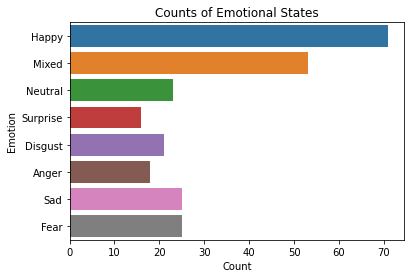

In [29]:
sns.countplot(y='emotion_ecg', data=signals_ecg)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

In [30]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [33]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
arr_shape

1000

### Apply SMOTE to the training data

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [37]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [38]:
len(y_smote)

432

In [39]:
from tensorflow.keras.utils import to_categorical

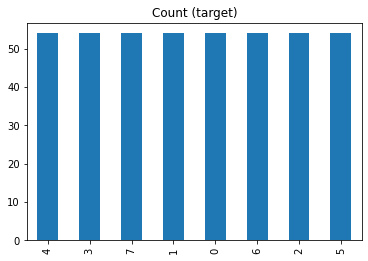

In [40]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER FOR FEATURE EXTRACTION

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [42]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [43]:
autoencoder_smote.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 128)               2048      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                2080

In [44]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [45]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 [==============================] - 3s 28ms/step - loss: 0.9052 - val_loss: 1.1671
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 0.7022 - val_loss: 1.0951
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6134 - val_loss: 1.0235
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5709 - val_loss: 0.9568
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5396 - val_loss: 0.8953
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5244 - val_loss: 0.8382
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5107 - val_loss: 0.7915
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4922 - val_loss: 0.7494
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4854 - val_loss: 0.7144
Epoch 10/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4829 - val_loss: 0.6859
Epoch 1

Epoch 83/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4260 - val_loss: 0.5359
Epoch 84/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4265 - val_loss: 0.5354
Epoch 85/100
14/14 [==============================] - 0s 10ms/step - loss: 0.4273 - val_loss: 0.5359
Epoch 86/100
14/14 [==============================] - 0s 11ms/step - loss: 0.4289 - val_loss: 0.5368
Epoch 87/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4275 - val_loss: 0.5365
Epoch 88/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4267 - val_loss: 0.5370
Epoch 89/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4259 - val_loss: 0.5363
Epoch 90/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4260 - val_loss: 0.5351
Epoch 91/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4257 - val_loss: 0.5354
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4255 - val_loss: 0.535

In [46]:
def plot_training_history(history, title='Model Training History'):
    """
    Plots the training history of a Keras model.

    Parameters:
    - history: return value from model.fit() method
    - title: string, title of the plot
    """
    
    # Plot training & validation accuracy values
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(title + ' - Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

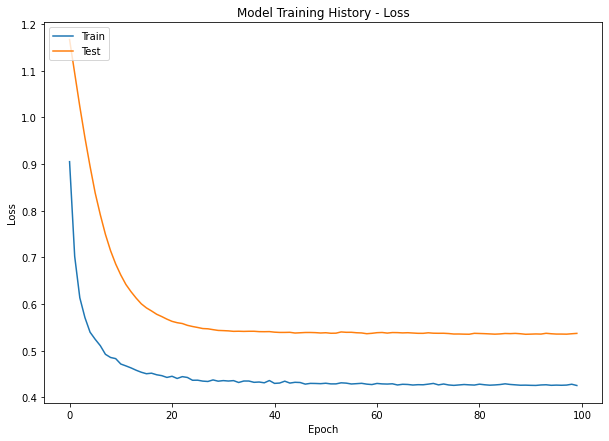

In [47]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [48]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


### PCA ON STATISTICAL FEATURES 

In [49]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [50]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [51]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [52]:
from sklearn.decomposition import PCA

In [53]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [54]:
from scipy.fftpack import fft, ifft
import pywt

In [55]:
signals_df = ecg_signals.copy()

In [56]:
signals_df = signals_df[['feature_ecg', 'emotion_ecg']]
signals_df.head()

,feature_ecg,emotion_ecg
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",Happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",Happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",Mixed
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",Neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",Surprise


In [57]:
def apply_fourier_transform_ecg(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [58]:
# Apply Fourier Transform to each row in the DataFrame
feature_ecg_fft = np.array([apply_fourier_transform_ecg(arr) for arr in signals_df['feature_ecg']])

In [59]:
# Convert to DataFrame
feature_ecg_fft_df = pd.DataFrame(feature_ecg_fft, columns=[f'feature_ecg_fft_{i}' for i in range(feature_ecg_fft.shape[1])])

In [60]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_df.drop(['feature_ecg', 'emotion_ecg'], axis=1),
               feature_ecg_fft_df], axis=1)

# Splitting the data
y = signals_df['emotion_ecg']  # Target column

In [61]:
X.columns

Index(['feature_ecg_fft_0', 'feature_ecg_fft_1', 'feature_ecg_fft_2',
       'feature_ecg_fft_3', 'feature_ecg_fft_4', 'feature_ecg_fft_5',
       'feature_ecg_fft_6', 'feature_ecg_fft_7', 'feature_ecg_fft_8',
       'feature_ecg_fft_9', 'feature_ecg_fft_10', 'feature_ecg_fft_11',
       'feature_ecg_fft_12', 'feature_ecg_fft_13', 'feature_ecg_fft_14',
       'feature_ecg_fft_15', 'feature_ecg_fft_16', 'feature_ecg_fft_17',
       'feature_ecg_fft_18', 'feature_ecg_fft_19'],
      dtype='object')

In [62]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [64]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Apply SMOTE to the training data

In [65]:
smote_fft = SMOTE(sampling_strategy='auto', random_state=42)
X_fft_smote, y_fft_smote = smote_fft.fit_resample(X_train_fft, y_train_fft)

### WAVELET TRANSFORM

In [66]:
def apply_wavelet_transform_ecg(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [67]:
# Apply Wavelet Transform to each row in the DataFrame
feature_ecg_wavelet = np.array([apply_wavelet_transform_ecg(arr) for arr in signals_df['feature_ecg']])

In [68]:
# Convert to DataFrame
feature_ecg_wavelet_df = pd.DataFrame(feature_ecg_wavelet, columns=[f'feature_ecg_wavelet_{i}' for i in range(feature_ecg_wavelet.shape[1])])

In [69]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_df.drop(['feature_ecg', 'emotion_ecg'], axis=1),
               feature_ecg_wavelet_df], axis=1)

# Splitting the data
y = signals_df['emotion_ecg']  # Target column

In [70]:
X.columns

Index(['feature_ecg_wavelet_0', 'feature_ecg_wavelet_1',
       'feature_ecg_wavelet_2', 'feature_ecg_wavelet_3',
       'feature_ecg_wavelet_4', 'feature_ecg_wavelet_5',
       'feature_ecg_wavelet_6', 'feature_ecg_wavelet_7',
       'feature_ecg_wavelet_8', 'feature_ecg_wavelet_9',
       'feature_ecg_wavelet_10', 'feature_ecg_wavelet_11',
       'feature_ecg_wavelet_12', 'feature_ecg_wavelet_13',
       'feature_ecg_wavelet_14', 'feature_ecg_wavelet_15',
       'feature_ecg_wavelet_16', 'feature_ecg_wavelet_17',
       'feature_ecg_wavelet_18', 'feature_ecg_wavelet_19'],
      dtype='object')

In [71]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [72]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Apply SMOTE to the training data

In [73]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

## Define the functions going to be used for the analysis

In [78]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The fit_and_score_models function trains multiple machine learning models, evaluates their performance on test data, and provides metrics (accuracy, precision, recall, F1 score) along with visualizations of confusion matrices of each model for comparison and analysis

In [74]:
# Define individual models
models = [
    DecisionTreeClassifier(criterion="entropy", max_depth=12),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(n_neighbors=25),
    XGBClassifier(max_depth=2, gamma=2, eta=0.8, reg_alpha=0.5, reg_lambda=0.5)
]

In [75]:
def fit_and_score_models(models, X_train, X_test, y_train, y_test):
    fitted_models = []
    model_names = []
    training_accuracy = []
    testing_accuracy = []
    testing_precision = []
    testing_recall = []
    testing_f1 = []
    
    # Define your emotion labels
    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Mixed', 'Neutral', 'Sad', 'Surprised']

    for model in models:
        # Fit the model on the training data
        fitted_model = model.fit(X_train, y_train)
        fitted_models.append(fitted_model)
        
        # Get the name of the model
        model_name = model.__class__.__name__
        model_names.append(model_name)

        # Predict on the training and test data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        # Calculate other metrics for the test set
        test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        # Append metrics
        training_accuracy.append(train_accuracy)
        testing_accuracy.append(test_accuracy)
        testing_precision.append(test_precision)
        testing_recall.append(test_recall)
        testing_f1.append(test_f1)

        # Print classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred_test, labels=range(len(emotion_labels)), target_names=emotion_labels, zero_division=0))

        # Plot and display the confusion matrix
        plt.figure(figsize=(10, 8))
        conf_matrix = confusion_matrix(y_test, y_pred_test, labels=range(len(emotion_labels)))
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=emotion_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xticks(rotation=45)
        plt.show()

    # Create a summary DataFrame
    metrics_summary = pd.DataFrame({
        'Model': model_names,
        'Training Accuracy': training_accuracy,
        'Testing Accuracy': testing_accuracy,
        'Testing Precision': testing_precision,
        'Testing Recall': testing_recall,
        'Testing F1 Score': testing_f1
    })

    return metrics_summary, fitted_models

The cross_validate_models_smote function performs Leave-One-Out cross-validation on multiple models with SMOTE-enhanced data, calculates key performance metrics, and generates confusion matrices for each model.

In [76]:
def cross_validate_models_smote(models, X_train, y_train, labels):
    cv_results = []
    loo = LeaveOneOut()

    # If y_train is one-hot encoded, convert it to label encoded
    if y_train.ndim > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)

    for model in models:
        model_name = model.__class__.__name__
        print(f"Cross-validating {model_name}...")

        # Perform Leave-One-Out cross-validation and collect predictions
        y_pred_loo = cross_val_predict(model, X_train, y_train, cv=loo)
        
        # Calculate metrics
        accuracy = accuracy_score(y_train, y_pred_loo)
        precision = precision_score(y_train, y_pred_loo, average='weighted', zero_division=0)
        recall = recall_score(y_train, y_pred_loo, average='weighted', zero_division=0)
        f1 = f1_score(y_train, y_pred_loo, average='weighted', zero_division=0)

        # Compile the results
        cv_results.append({
            'Model': model_name,
            'CV Accuracy': accuracy,
            'CV Precision': precision,
            'CV Recall': recall,
            'CV F1 Score': f1
        })

        # Print classification report and confusion matrix
        print(f"Plotting confusion matrix for {model_name}...")
        cm = confusion_matrix(y_train, y_pred_loo, labels=np.arange(len(labels)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xticks(rotation=45)
        # Save the figure
        plt.savefig(f'confusion_matrix_{model_name}.png', bbox_inches='tight')
        plt.tight_layout()
        plt.show()

    # Create a summary DataFrame from cv_results
    cv_summary = pd.DataFrame(cv_results)
    return cv_summary.sort_values(by='CV Accuracy', ascending=False)

emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Mixed', 'Neutral', 'Sad', 'Surprised']

This function takes in the results from the cross validation models and plots all the models together for comparison

In [241]:
def plot_cross_validation_results(data, save_filename, title):
    # Create a DataFrame from the provided data
    df = pd.DataFrame(data)

    # Define metrics to plot
    metrics = ["Cross Validation Mean Accuracy", "Cross Validation Mean Precision", 
               "Cross Validation Mean Recall", "Cross Validation Mean F1 Score"]

    # Plot setup
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18), sharey=True)
    title_fontsize = 16  # Font size for titles
    axis_fontsize = 14   # Font size for axis labels and ticks

    # Plot each metric
    for ax, metric in zip(axes.flatten(), metrics):
        sns.barplot(x="Feature Extraction", y=metric, hue="Model", data=df, ax=ax)
        ax.set_title(metric, fontsize=title_fontsize)
        ax.set_xlabel(ax.get_xlabel(), fontsize=axis_fontsize)
        ax.set_ylabel(ax.get_ylabel(), fontsize=axis_fontsize)
        ax.tick_params(axis='x', labelrotation=45, labelsize=axis_fontsize)
        ax.tick_params(axis='y', labelsize=axis_fontsize)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', fontsize=axis_fontsize)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.93)

    # Save the plot
    plt.savefig(save_filename)
    plt.show()

### Displaying the results for ECG signals

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.17      0.20      0.18         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.43      0.50      0.46         6
       Happy       0.24      0.25      0.24        20
       Mixed       0.21      0.19      0.20        16
     Neutral       0.38      0.27      0.32        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.33      0.40      0.36         5

    accuracy                           0.22        76
   macro avg       0.22      0.23      0.22        76
weighted avg       0.23      0.22      0.22        76



<Figure size 720x576 with 0 Axes>

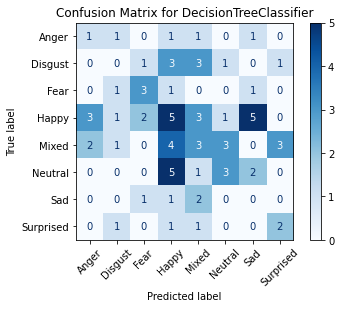

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.29      0.33      0.31         6
       Happy       0.40      0.60      0.48        20
       Mixed       0.47      0.44      0.45        16
     Neutral       0.43      0.27      0.33        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.67      0.40      0.50         5

    accuracy                           0.36        76
   macro avg       0.31      0.28      0.29        76
weighted avg       0.35      0.36      0.34        76



<Figure size 720x576 with 0 Axes>

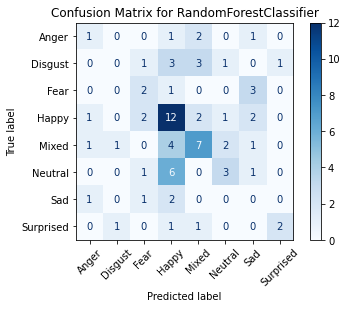

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.60      0.36        20
       Mixed       0.22      0.31      0.26        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.11      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 720x576 with 0 Axes>

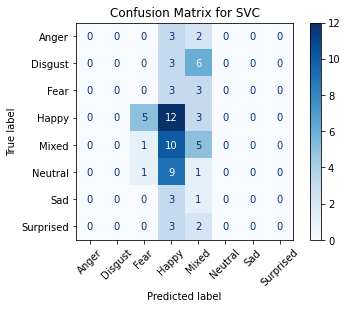

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.30      0.65      0.41        20
       Mixed       0.14      0.19      0.16        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.20      0.17      0.14        76
weighted avg       0.19      0.25      0.18        76



<Figure size 720x576 with 0 Axes>

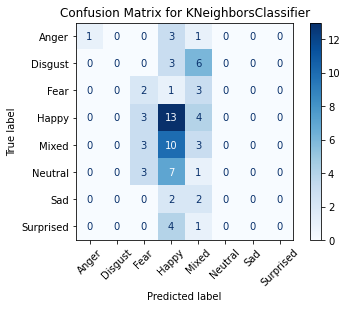

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.25      0.11      0.15         9
        Fear       0.67      0.33      0.44         6
       Happy       0.41      0.80      0.54        20
       Mixed       0.32      0.50      0.39        16
     Neutral       1.00      0.09      0.17        11
         Sad       0.33      0.25      0.29         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.39        76
   macro avg       0.50      0.29      0.29        76
weighted avg       0.49      0.39      0.34        76



<Figure size 720x576 with 0 Axes>

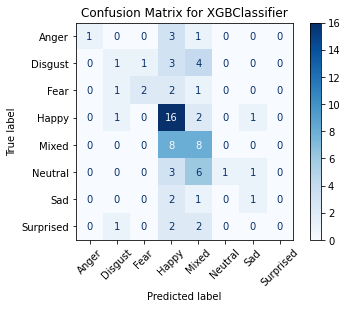

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.223684   
 1  RandomForestClassifier           0.784091          0.355263   
 2                     SVC           0.369318          0.223684   
 3    KNeighborsClassifier           0.357955          0.250000   
 4           XGBClassifier           0.500000          0.394737   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.228775        0.223684          0.224319  
 1           0.348402        0.355263          0.341444  
 2           0.114416        0.223684          0.149675  
 3           0.189778        0.250000          0.183250  
 4           0.485638        0.394737          0.339283  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [79]:
summary_ecg_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_ecg_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


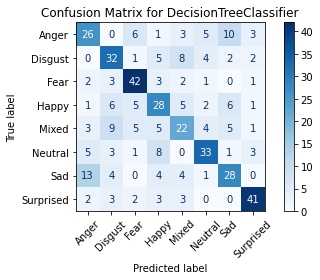

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


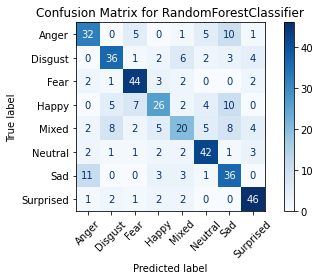

Cross-validating SVC...
Plotting confusion matrix for SVC...


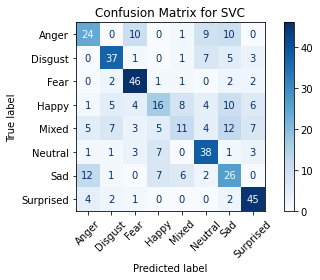

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


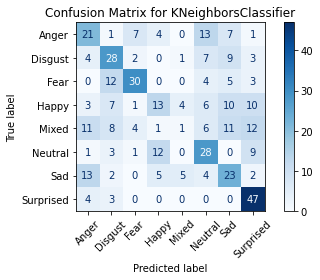

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


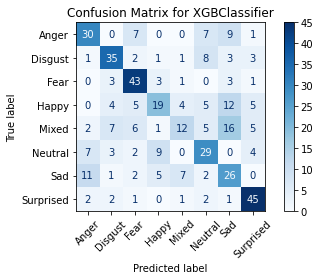

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.652778,0.647433,0.652778,0.645614
0,DecisionTreeClassifier,0.583333,0.582124,0.583333,0.581595
2,SVC,0.562500,0.544382,0.562500,0.544049
4,XGBClassifier,0.553241,0.546356,0.553241,0.540104
3,KNeighborsClassifier,0.442130,0.405096,0.442130,0.411770


In [80]:
summary_smote_ecg_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_ecg_autoencoder

### Statistical features with imbalanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


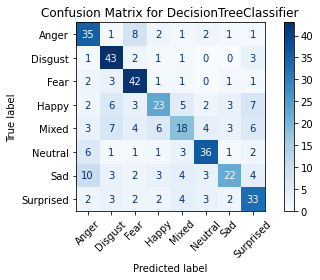

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


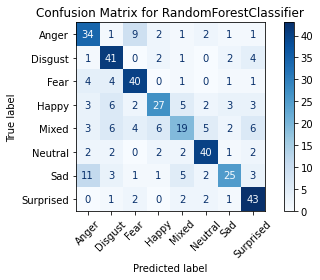

Cross-validating SVC...
Plotting confusion matrix for SVC...


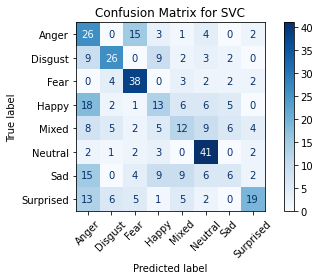

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


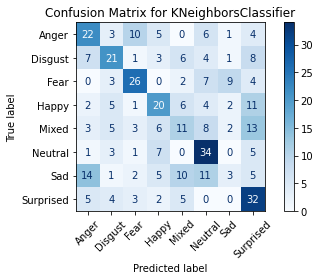

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


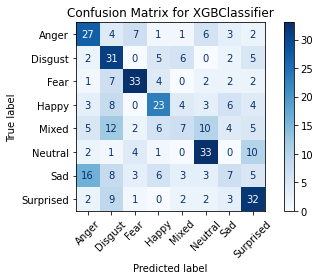

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.659314,0.656371,0.659314,0.649920
0,DecisionTreeClassifier,0.617647,0.614207,0.617647,0.606530
4,XGBClassifier,0.473039,0.453532,0.473039,0.452098
2,SVC,0.443627,0.440270,0.443627,0.424408
3,KNeighborsClassifier,0.414216,0.391913,0.414216,0.393140


In [81]:
summary_pca_ecg_stats = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_pca_ecg_stats

### Fourier transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.14      0.33      0.20         3
     Disgust       0.20      0.20      0.20         5
        Fear       0.67      0.44      0.53         9
       Happy       0.43      0.38      0.40        24
       Mixed       0.26      0.33      0.29        15
     Neutral       0.12      0.11      0.12         9
         Sad       0.00      0.00      0.00         7
   Surprised       0.00      0.00      0.00         4

    accuracy                           0.28        76
   macro avg       0.23      0.22      0.22        76
weighted avg       0.30      0.28      0.28        76



<Figure size 720x576 with 0 Axes>

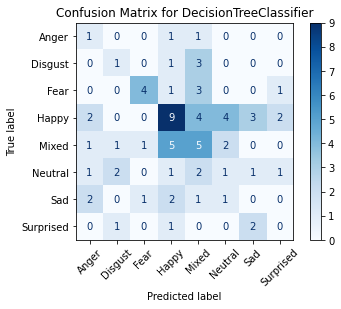

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.33      0.40         3
     Disgust       0.00      0.00      0.00         5
        Fear       0.50      0.22      0.31         9
       Happy       0.35      0.54      0.43        24
       Mixed       0.29      0.40      0.33        15
     Neutral       0.20      0.11      0.14         9
         Sad       0.00      0.00      0.00         7
   Surprised       1.00      0.25      0.40         4

    accuracy                           0.32        76
   macro avg       0.35      0.23      0.25        76
weighted avg       0.32      0.32      0.29        76



<Figure size 720x576 with 0 Axes>

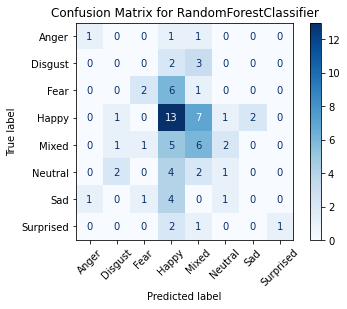

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.50      0.33      0.40         3
     Disgust       0.00      0.00      0.00         5
        Fear       0.67      0.22      0.33         9
       Happy       0.39      0.50      0.44        24
       Mixed       0.22      0.47      0.30        15
     Neutral       0.43      0.33      0.38         9
         Sad       0.00      0.00      0.00         7
   Surprised       0.00      0.00      0.00         4

    accuracy                           0.33        76
   macro avg       0.28      0.23      0.23        76
weighted avg       0.31      0.33      0.30        76



<Figure size 720x576 with 0 Axes>

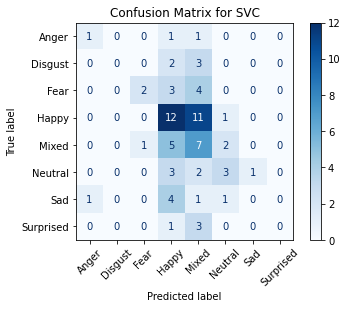

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         3
     Disgust       0.00      0.00      0.00         5
        Fear       0.20      0.22      0.21         9
       Happy       0.30      0.71      0.42        24
       Mixed       0.25      0.07      0.11        15
     Neutral       0.00      0.00      0.00         9
         Sad       0.00      0.00      0.00         7
   Surprised       0.00      0.00      0.00         4

    accuracy                           0.26        76
   macro avg       0.09      0.12      0.09        76
weighted avg       0.17      0.26      0.18        76



<Figure size 720x576 with 0 Axes>

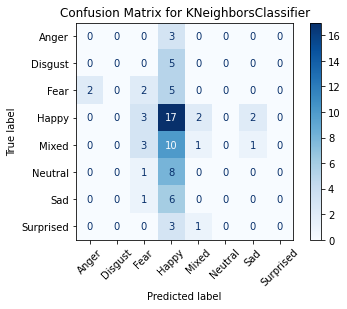

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.33      0.40         3
     Disgust       0.00      0.00      0.00         5
        Fear       0.67      0.22      0.33         9
       Happy       0.35      0.58      0.44        24
       Mixed       0.25      0.33      0.29        15
     Neutral       0.33      0.33      0.33         9
         Sad       0.00      0.00      0.00         7
   Surprised       0.00      0.00      0.00         4

    accuracy                           0.33        76
   macro avg       0.26      0.23      0.22        76
weighted avg       0.30      0.33      0.29        76



<Figure size 720x576 with 0 Axes>

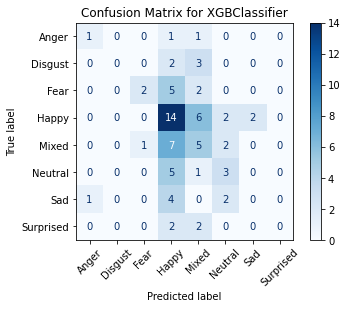

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.795455          0.276316   
 1  RandomForestClassifier           0.795455          0.315789   
 2                     SVC           0.619318          0.328947   
 3    KNeighborsClassifier           0.346591          0.263158   
 4           XGBClassifier           0.579545          0.328947   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.299824        0.276316          0.282508  
 1           0.322607        0.315789          0.290585  
 2           0.314852        0.328947          0.296261  
 3           0.167209        0.263158          0.178260  
 4           0.298026        0.328947          0.289286  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [82]:
summary_ecg_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_ecg_fft

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


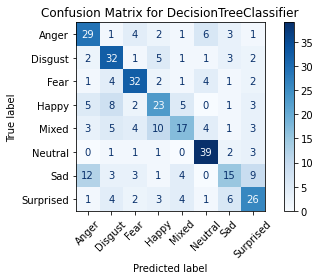

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


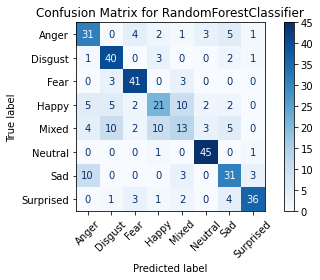

Cross-validating SVC...
Plotting confusion matrix for SVC...


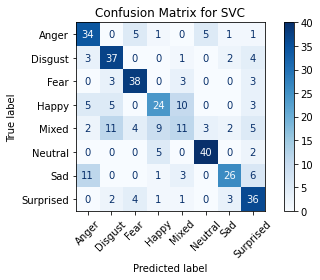

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


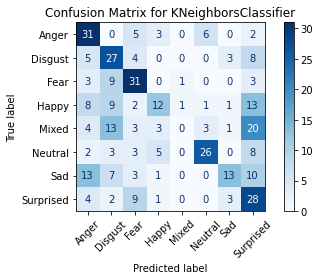

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


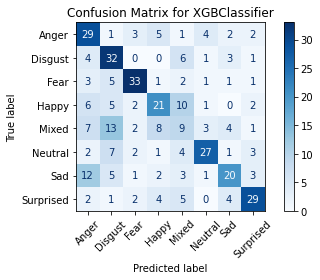

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.686170,0.671501,0.686170,0.674213
2,SVC,0.654255,0.645491,0.654255,0.642356
0,DecisionTreeClassifier,0.566489,0.558115,0.566489,0.557084
4,XGBClassifier,0.531915,0.542586,0.531915,0.530070
3,KNeighborsClassifier,0.446809,0.433857,0.446809,0.414495


In [84]:
summary_smote_ecg_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_ecg_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.17      0.11      0.13         9
        Fear       0.33      0.67      0.44         6
       Happy       0.35      0.30      0.32        20
       Mixed       0.18      0.19      0.18        16
     Neutral       0.44      0.36      0.40        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.25      0.20      0.22         5

    accuracy                           0.26        76
   macro avg       0.25      0.25      0.24        76
weighted avg       0.27      0.26      0.26        76



<Figure size 720x576 with 0 Axes>

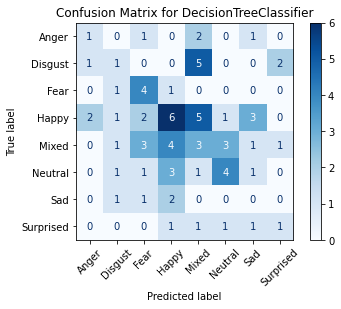

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       1.00      0.33      0.50         6
       Happy       0.32      0.65      0.43        20
       Mixed       0.25      0.25      0.25        16
     Neutral       0.43      0.27      0.33        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.33      0.20      0.25         5

    accuracy                           0.32        76
   macro avg       0.35      0.24      0.26        76
weighted avg       0.33      0.32      0.29        76



<Figure size 720x576 with 0 Axes>

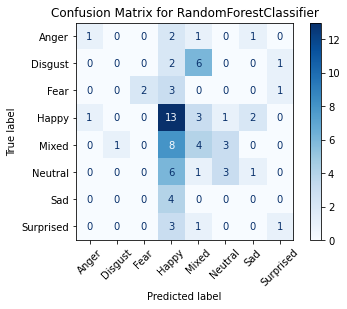

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       1.00      0.33      0.50         6
       Happy       0.27      0.70      0.39        20
       Mixed       0.15      0.12      0.14        16
     Neutral       0.43      0.27      0.33        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.28        76
   macro avg       0.23      0.18      0.17        76
weighted avg       0.25      0.28      0.22        76



<Figure size 720x576 with 0 Axes>

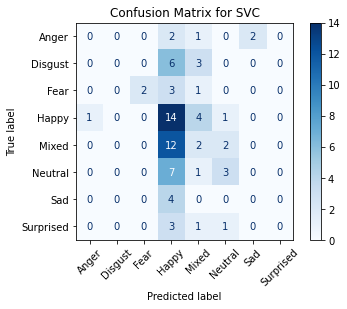

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.25      0.50      0.33         6
       Happy       0.25      0.65      0.37        20
       Mixed       0.18      0.12      0.15        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.15      0.18      0.14        76
weighted avg       0.16      0.25      0.17        76



<Figure size 720x576 with 0 Axes>

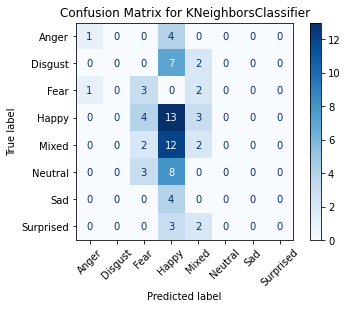

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.67      0.33      0.44         6
       Happy       0.32      0.60      0.41        20
       Mixed       0.18      0.25      0.21        16
     Neutral       0.33      0.27      0.30        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.29        76
   macro avg       0.31      0.21      0.21        76
weighted avg       0.29      0.29      0.25        76



<Figure size 720x576 with 0 Axes>

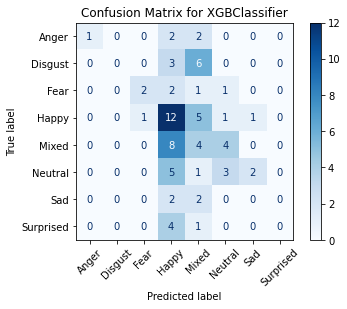

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.263158   
 1  RandomForestClassifier           0.784091          0.315789   
 2                     SVC           0.602273          0.276316   
 3    KNeighborsClassifier           0.357955          0.250000   
 4           XGBClassifier           0.522727          0.289474   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.273306        0.263158          0.261638  
 1           0.331874        0.315789          0.287761  
 2           0.245606        0.276316          0.220538  
 3           0.157989        0.250000          0.172670  
 4           0.288047        0.289474          0.253653  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [85]:
summary_ecg_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_ecg_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


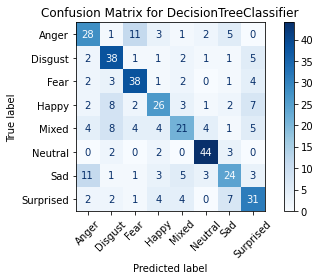

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


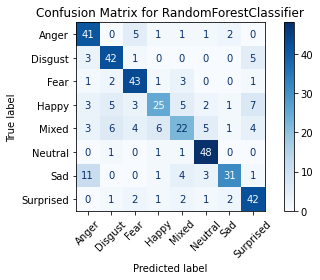

Cross-validating SVC...
Plotting confusion matrix for SVC...


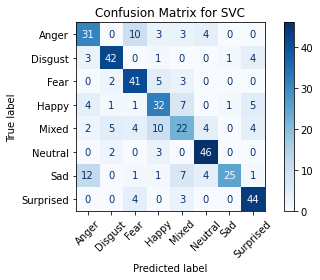

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


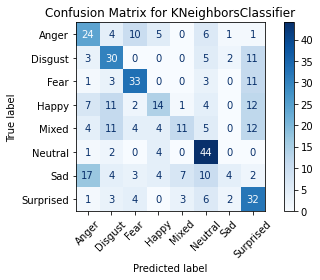

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


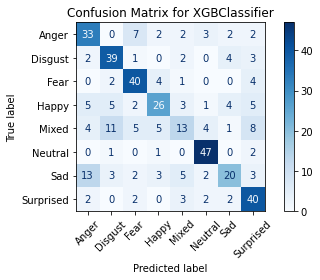

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.720588,0.718843,0.720588,0.710962
2,SVC,0.693627,0.703042,0.693627,0.688016
4,XGBClassifier,0.632353,0.619843,0.632353,0.615328
0,DecisionTreeClassifier,0.612745,0.607500,0.612745,0.606571
3,KNeighborsClassifier,0.470588,0.470687,0.470588,0.434890


In [86]:
summary_smote_ecg_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_ecg_wt

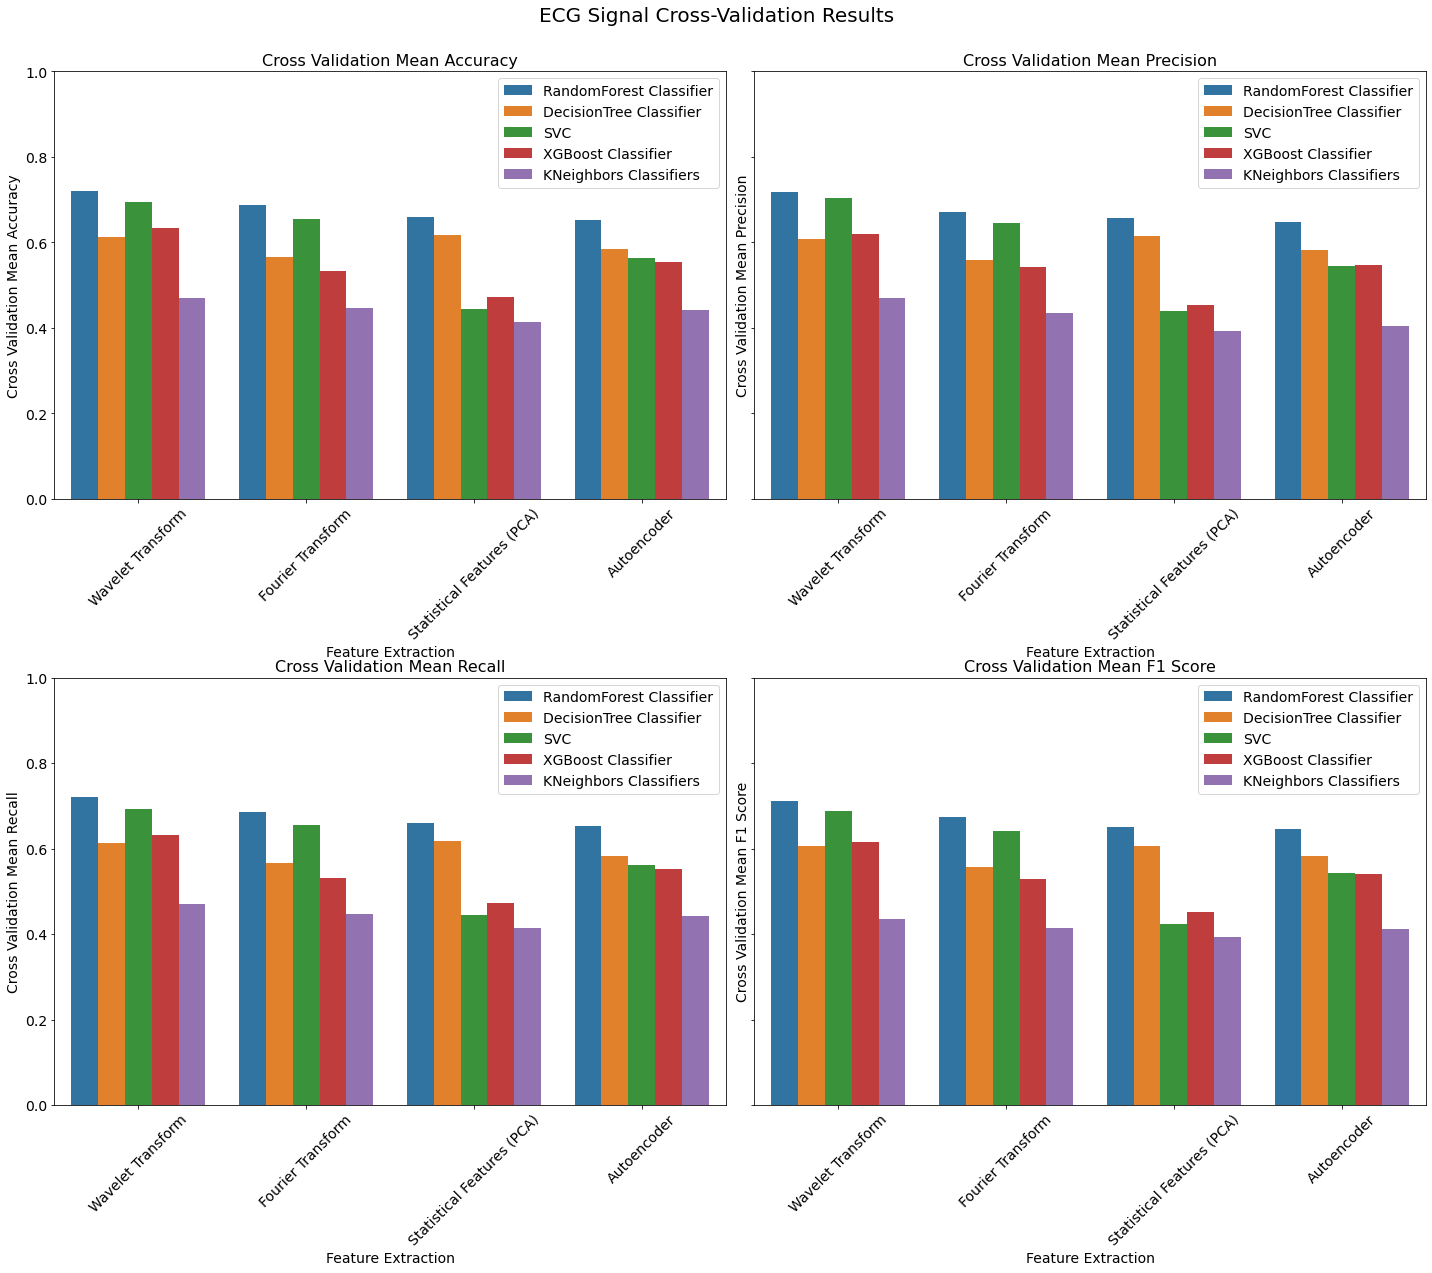

In [242]:
# Results data
data_ecg = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.7206, 0.6127, 0.6936, 0.6324, 0.4706,
        0.686170, 0.566489, 0.654255, 0.531915, 0.446809,
        0.659314, 0.617647, 0.443627, 0.473039, 0.414216,
        0.652778, 0.583333, 0.562500, 0.553241, 0.442130
    ],
    "Cross Validation Mean Precision": [
        0.7188, 0.6075, 0.7030, 0.6198, 0.4707,
        0.671501, 0.558115, 0.645491, 0.542586, 0.433857,
        0.656371, 0.614207, 0.440270, 0.453532, 0.391913,
        0.647433, 0.582124, 0.544382, 0.546356, 0.405096
    ],
    "Cross Validation Mean Recall": [
        0.7206, 0.612745, 0.6936, 0.6324, 0.4706,
        0.686170, 0.566489, 0.654255, 0.531915, 0.446809,
        0.659314, 0.617647, 0.443627, 0.473039, 0.414216,
        0.652778, 0.583333, 0.562500, 0.553241, 0.442130
    ],
    "Cross Validation Mean F1 Score": [
        0.7110, 0.6066, 0.6880, 0.6153, 0.4349,
        0.674213, 0.557084, 0.642356, 0.530070, 0.414495,
        0.649920, 0.606530, 0.424408, 0.452098, 0.393140,
        0.645614, 0.581595, 0.544049, 0.540104, 0.411770
    ]
}


plot_cross_validation_results(data_ecg, 'results_comparison_ecg.png', "ECG Signal Cross-Validation Results")

## EXTRACT THE FEATURES FROM THE GSR SIGNALS

In [88]:
# Column order for the resulting dataframe
cols_gsr = ['Raw Data'] + list(self_annotation_multimodal.columns)
print(cols_gsr)

['Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label', 'Annotation']


In [89]:
arr_shape = 1000
raw_data_arr1 = []

def form_data_gsr(df_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('GSRdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = self_annotation_multimodal.loc[(self_annotation_multimodal['Session ID'] == int(s)) & 
                             (self_annotation_multimodal['Participant Id'] == int(p)) & 
                             (self_annotation_multimodal['Video ID'] == int(v)) &
                             (self_annotation_multimodal['Annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              df_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['Annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return df_array

In [90]:
raw_data_arr1 =  form_data_gsr(df_array = raw_data_arr1, annotation = 'M', data_path = "C:/Users/MR EVANS/Desktop/HUMAN EMOTION ANALYSIS/ECG_GSR_Emotions/Raw Data/Multimodal/GSR")

cols_gsr.append('Target Emotion')
raw_dataframe_gsr = pd.DataFrame(raw_data_arr1, columns = cols_gsr)
raw_dataframe_gsr.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe_gsr['Familiarity Score'] = raw_dataframe_gsr['Familiarity Score'].fillna('Never watched')
raw_dataframe_gsr = raw_dataframe_gsr.replace(np.nan, '', regex=True)
raw_dataframe_gsr.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[357.72, 357.43, 357.32, 357.24, 356.95, 357.0...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[438.26, 437.83, 438.21, 438.14, 438.2, 438.15...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


In [91]:
gsr_dataframe = raw_dataframe_gsr.copy()
gsr_dataframe.head(2)

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy


In [92]:
def plot_gsr_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        try:
            plt.plot(y, label='Session {}'.format(row['Session ID']))
            plt.legend()
        except:
            plt.plot(y)
        
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [93]:
def PlotGSR(df, participant_id=10, target_emotion='sad'):
    return df[(df['Participant ID']==participant_id)&(df['Target Emotion']==target_emotion)]

<Figure size 432x288 with 0 Axes>

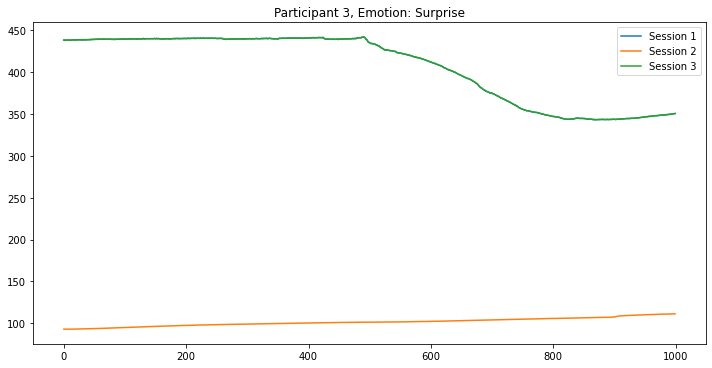

In [94]:
plot_gsr_signals(PlotGSR(gsr_dataframe, 3, 'surprise'), title='Participant 3, Emotion: Surprise')

<Figure size 432x288 with 0 Axes>

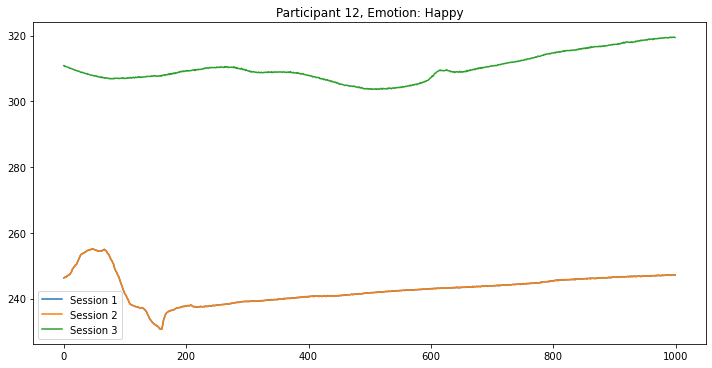

In [95]:
plot_gsr_signals(PlotGSR(gsr_dataframe, 12, 'happy'), title='Participant 12, Emotion: Happy')

In [96]:
gsr_dataframe.drop(['Video ID', 'Happy', 'Sad', 'Fear','Anger', 'Neutral', 'Disgust', 'Surprised', 
                                    'Four label', 'Session ID', 'Familiarity Score', 'Age', 
                                    'Gender', 'Name'], axis = 1).head()

,Raw Data,Participant ID,Valence level,Arousal level,Dominance level,Emotion,Valence,Arousal,Annotation,Target Emotion
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,8,3,0,Happy,HV,LA,M,happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,9,7,0,Happy,HV,HA,M,happy
2,"[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",10,5,4,2,Mixed,LV,LA,M,sad
3,"[357.72, 357.43, 357.32, 357.24, 356.95, 357.0...",10,4,0,0,Neutral,LV,LA,M,neutral
4,"[438.26, 437.83, 438.21, 438.14, 438.2, 438.15...",10,7,6,0,Surprise,HV,HA,M,surprise


In [97]:
gsr_dataframe.rename(columns = {'Raw Data':'feature_gsr', 'Emotion':'emotion_gsr'}, inplace = True)
gsr_dataframe.head(3)

,feature_gsr,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,emotion_gsr,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad


In [98]:
gsr_signals = gsr_dataframe.copy()
gsr_signals.head()

,feature_gsr,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,emotion_gsr,Valence,Arousal,Four label,Annotation,Target Emotion
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[357.72, 357.43, 357.32, 357.24, 356.95, 357.0...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[438.26, 437.83, 438.21, 438.14, 438.2, 438.15...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


### STASTICAL FEATURES - GSR

In [99]:
gsr_signals['meanrr_gsr'] = meanrr
gsr_signals['medianrr_gsr'] = medianrr
gsr_signals['sdrr_gsr'] = sdrr
gsr_signals['rmssd_gsr'] = rmssd
gsr_signals['sdrr_rmssd_gsr'] = sdrr_rmssd
gsr_signals['hr_gsr'] = hr
gsr_signals['NNx_gsr'] = NNx
gsr_signals['pNNx_gsr'] = pNNx
gsr_signals['sd1_gsr'] = SD1
gsr_signals['sd2_gsr'] = SD2
gsr_signals['avrr_gsr'] = avrr
gsr_signals['skew_gsr'] = skew_
gsr_signals['kurt_gsr'] = kurt
gsr_signals['avrr_gsr'] = avrr
gsr_signals['csi_gsr'] = CSI
gsr_signals['modifiedcvi_gsr'] = modifiedCVI

### Filter emotion by 'Emotion' and 'Participant ID'

In [100]:
def filter_by_id_and_emotion(emotion, participant_id):
    """Filter the DataFrame based on the emotion and Participant ID."""
    filter_emotion = gsr_signals[(gsr_signals['emotion_gsr'] == emotion) & (gsr_signals['Participant ID'] == participant_id)]
    return filter_emotion

In [101]:
Surprise_1 = filter_by_id_and_emotion('Surprise', 1)
Surprise_1

,feature_gsr,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
23,"[254.98, 254.91, 255.06, 255.02, 255.05, 255.1...",1,1,2,M_M,13,Female,4,0,0,...,328.141952,0,0.0,0.063467,0.320342,6.871741,3.092340,14.083283,0.198123,0.050297
106,"[805.45, 805.52, 805.19, 805.19, 805.75, 805.5...",1,2,2,M_M,13,Female,0,0,0,...,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392


In [102]:
signals_gsr = gsr_signals.drop(['feature_gsr', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Target Emotion',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Annotation',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label'], axis=1)

In [103]:
signals_gsr

,emotion_gsr,meanrr_gsr,medianrr_gsr,sdrr_gsr,rmssd_gsr,sdrr_rmssd_gsr,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,Happy,208.375000,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,Happy,208.375000,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,Mixed,209.625000,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,Neutral,189.000000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,Surprise,219.500000,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Mixed,152.200000,153.00,0.250897,0.085570,2.932081,394.447092,0,0.0,0.060537,0.349620,3.230677,4.406868,20.993468,0.173151,0.041928
248,Surprise,219.500000,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066
249,Surprise,171.900000,172.00,0.249608,0.080996,3.081730,349.148724,0,0.0,0.057301,0.348317,3.680474,4.123410,18.741587,0.164510,0.037707
250,Surprise,174.500000,176.50,0.230885,0.076856,3.004124,344.505246,0,0.0,0.054373,0.321962,3.976598,4.280082,19.892723,0.168879,0.036730


In [104]:
signals_gsr.columns

Index(['emotion_gsr', 'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr',
       'sdrr_rmssd_gsr', 'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr',
       'avrr_gsr', 'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [105]:
X = signals_gsr.drop(['emotion_gsr'], axis=1)
y = signals_gsr['emotion_gsr']

In [106]:
X.head()

,meanrr_gsr,medianrr_gsr,sdrr_gsr,rmssd_gsr,sdrr_rmssd_gsr,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066


In [107]:
y[:10]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
5     Disgust
6       Anger
7       Happy
8         Sad
9     Neutral
Name: emotion_gsr, dtype: object

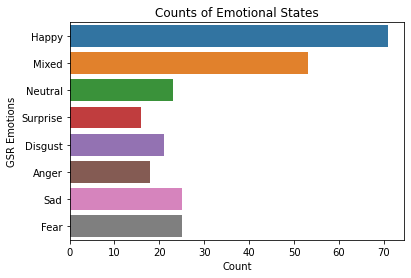

In [108]:
sns.countplot(y='emotion_gsr', data=gsr_signals)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('GSR Emotions')
plt.show()

In [109]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [110]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [112]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [113]:
arr_shape

1000

#### Applying SMOTE to the training data

In [114]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [115]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [116]:
len(y_smote)

432

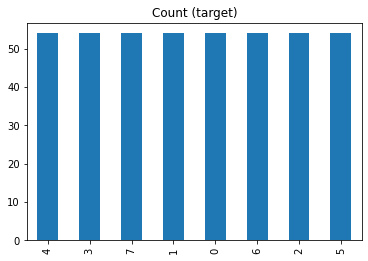

In [117]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER FOR FEATURE EXTRACTION

In [118]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [119]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# input_layer = Input(shape=(X_train_encoder[1],))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [120]:
autoencoder_smote.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_5 (Dense)             (None, 128)               2048      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 32)                2080

In [121]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [122]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 [==============================] - 4s 35ms/step - loss: 0.9249 - val_loss: 1.1517
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.7178 - val_loss: 1.0889
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6269 - val_loss: 1.0220
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5759 - val_loss: 0.9565
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5460 - val_loss: 0.8978
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5306 - val_loss: 0.8438
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5099 - val_loss: 0.7959
Epoch 8/100
14/14 [==============================] - 0s 11ms/step - loss: 0.5013 - val_loss: 0.7541
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4891 - val_loss: 0.7210
Epoch 10/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4906 - val_loss: 0.6929
Epoch

14/14 [==============================] - 0s 12ms/step - loss: 0.4276 - val_loss: 0.5372
Epoch 83/100
14/14 [==============================] - 0s 11ms/step - loss: 0.4260 - val_loss: 0.5374
Epoch 84/100
14/14 [==============================] - 0s 10ms/step - loss: 0.4265 - val_loss: 0.5378
Epoch 85/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4258 - val_loss: 0.5372
Epoch 86/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4272 - val_loss: 0.5367
Epoch 87/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4271 - val_loss: 0.5364
Epoch 88/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4271 - val_loss: 0.5371
Epoch 89/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4258 - val_loss: 0.5367
Epoch 90/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4281 - val_loss: 0.5359
Epoch 91/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4263 - val_loss: 0.5366
Epoch 92/1

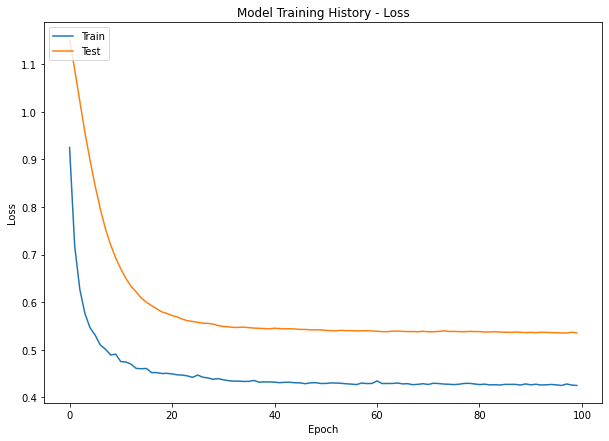

In [123]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [124]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [125]:
len(X_test_encoded)

76

In [126]:
len(X_test)

76

### PCA ON STATISTICAL FEATURES

In [127]:
from sklearn.decomposition import PCA

In [128]:
X = signals_gsr.drop(['emotion_gsr'], axis=1)
y = signals_gsr['emotion_gsr']

In [129]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [130]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [131]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [132]:
signals_data = gsr_signals.copy()

In [133]:
signals_data = signals_data[['feature_gsr', 'emotion_gsr']]
signals_data.head()

,feature_gsr,emotion_gsr
0,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",Happy
1,"[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",Happy
2,"[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",Mixed
3,"[357.72, 357.43, 357.32, 357.24, 356.95, 357.0...",Neutral
4,"[438.26, 437.83, 438.21, 438.14, 438.2, 438.15...",Surprise


In [134]:
def apply_fourier_transform_gsr(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [135]:
# Apply Fourier Transform to each row in the DataFrame
feature_gsr_fft = np.array([apply_fourier_transform_gsr(arr) for arr in signals_data['feature_gsr']])

In [136]:
# Convert to DataFrame
feature_gsr_fft_df = pd.DataFrame(feature_gsr_fft, columns=[f'feature_gsr_fft_{i}' for i in range(feature_ecg_fft.shape[1])])

In [137]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_data.drop(['feature_gsr', 'emotion_gsr'], axis=1),
               feature_gsr_fft_df], axis=1)

# Splitting the data
y = signals_data['emotion_gsr']  # Target column

In [138]:
X.columns

Index(['feature_gsr_fft_0', 'feature_gsr_fft_1', 'feature_gsr_fft_2',
       'feature_gsr_fft_3', 'feature_gsr_fft_4', 'feature_gsr_fft_5',
       'feature_gsr_fft_6', 'feature_gsr_fft_7', 'feature_gsr_fft_8',
       'feature_gsr_fft_9', 'feature_gsr_fft_10', 'feature_gsr_fft_11',
       'feature_gsr_fft_12', 'feature_gsr_fft_13', 'feature_gsr_fft_14',
       'feature_gsr_fft_15', 'feature_gsr_fft_16', 'feature_gsr_fft_17',
       'feature_gsr_fft_18', 'feature_gsr_fft_19'],
      dtype='object')

In [139]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_gsr, dtype: object

In [140]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [141]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [142]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Applying SMOTE to training data

In [143]:
smote_fft = SMOTE(sampling_strategy='auto', random_state=42)
X_fft_smote, y_fft_smote = smote_fft.fit_resample(X_train_fft, y_train_fft)

### WAVELET TRANSFORM

In [144]:
def apply_wavelet_transform_gsr(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [145]:
# Apply Wavelet Transform to each row in the DataFrame
feature_gsr_wavelet = np.array([apply_wavelet_transform_gsr(arr) for arr in signals_data['feature_gsr']])

In [146]:
# Convert to DataFrame
feature_gsr_wavelet_df = pd.DataFrame(feature_gsr_wavelet, columns=[f'feature_gsr_wavelet_{i}' for i in range(feature_gsr_wavelet.shape[1])])

In [147]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_data.drop(['feature_gsr', 'emotion_gsr'], axis=1),
               feature_gsr_wavelet_df], axis=1)

# Splitting the data
y = signals_data['emotion_gsr']  # Target column

In [148]:
X.columns

Index(['feature_gsr_wavelet_0', 'feature_gsr_wavelet_1',
       'feature_gsr_wavelet_2', 'feature_gsr_wavelet_3',
       'feature_gsr_wavelet_4', 'feature_gsr_wavelet_5',
       'feature_gsr_wavelet_6', 'feature_gsr_wavelet_7',
       'feature_gsr_wavelet_8', 'feature_gsr_wavelet_9',
       'feature_gsr_wavelet_10', 'feature_gsr_wavelet_11',
       'feature_gsr_wavelet_12', 'feature_gsr_wavelet_13',
       'feature_gsr_wavelet_14', 'feature_gsr_wavelet_15',
       'feature_gsr_wavelet_16', 'feature_gsr_wavelet_17',
       'feature_gsr_wavelet_18', 'feature_gsr_wavelet_19'],
      dtype='object')

In [149]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_gsr, dtype: object

In [150]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Applying SMOTE to training data

In [151]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

### Displaying the results for GSR signals

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.20      0.20      0.20         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.50      0.50      0.50         6
       Happy       0.30      0.35      0.33        20
       Mixed       0.29      0.25      0.27        16
     Neutral       0.38      0.27      0.32        11
         Sad       0.10      0.25      0.14         4
   Surprised       0.33      0.40      0.36         5

    accuracy                           0.28        76
   macro avg       0.26      0.28      0.26        76
weighted avg       0.27      0.28      0.27        76



<Figure size 720x576 with 0 Axes>

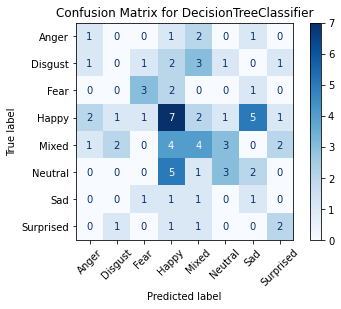

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.29      0.33      0.31         6
       Happy       0.41      0.60      0.49        20
       Mixed       0.36      0.31      0.33        16
     Neutral       0.50      0.27      0.35        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.33        76
   macro avg       0.28      0.26      0.26        76
weighted avg       0.32      0.33      0.32        76



<Figure size 720x576 with 0 Axes>

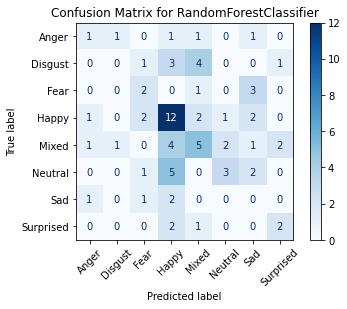

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.60      0.36        20
       Mixed       0.22      0.31      0.26        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.11      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 720x576 with 0 Axes>

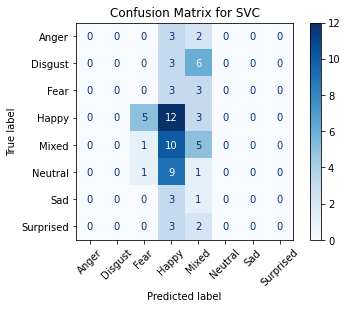

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.30      0.65      0.41        20
       Mixed       0.14      0.19      0.16        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.20      0.17      0.14        76
weighted avg       0.19      0.25      0.18        76



<Figure size 720x576 with 0 Axes>

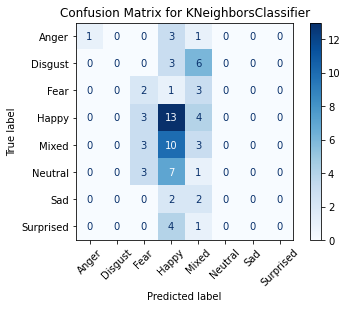

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.25      0.11      0.15         9
        Fear       0.67      0.33      0.44         6
       Happy       0.41      0.80      0.54        20
       Mixed       0.32      0.50      0.39        16
     Neutral       1.00      0.09      0.17        11
         Sad       0.33      0.25      0.29         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.39        76
   macro avg       0.50      0.29      0.29        76
weighted avg       0.49      0.39      0.34        76



<Figure size 720x576 with 0 Axes>

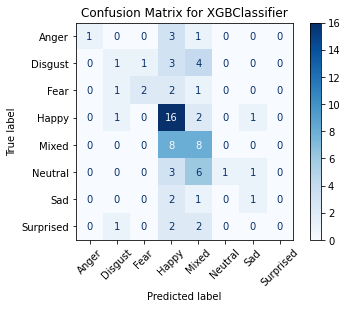

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.778409          0.276316   
 1  RandomForestClassifier           0.784091          0.328947   
 2                     SVC           0.369318          0.223684   
 3    KNeighborsClassifier           0.357955          0.250000   
 4           XGBClassifier           0.500000          0.394737   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.274343        0.276316          0.271600  
 1           0.321769        0.328947          0.315380  
 2           0.114416        0.223684          0.149675  
 3           0.189778        0.250000          0.183250  
 4           0.485638        0.394737          0.339283  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [152]:
summary_gsr_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_gsr_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


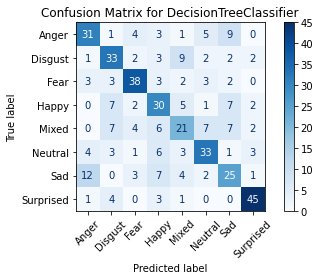

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


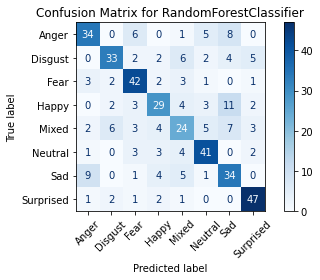

Cross-validating SVC...
Plotting confusion matrix for SVC...


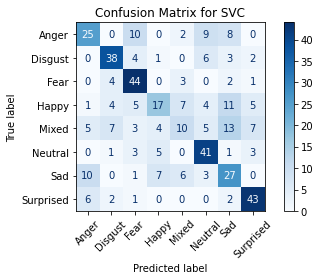

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


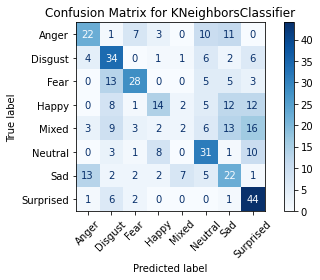

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


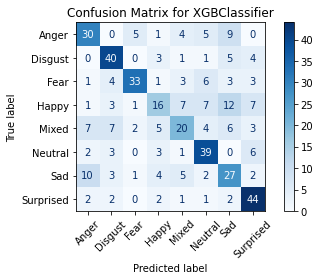

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.657407,0.656722,0.657407,0.654314
0,DecisionTreeClassifier,0.592593,0.591209,0.592593,0.591179
4,XGBClassifier,0.576389,0.573725,0.576389,0.567832
2,SVC,0.567130,0.549774,0.567130,0.548308
3,KNeighborsClassifier,0.456019,0.436399,0.456019,0.427078


In [153]:
summary_smote_gsr_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_gsr_autoencoder

### Statistical features with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.23      0.60      0.33         5
     Disgust       0.00      0.00      0.00         8
        Fear       0.44      0.80      0.57         5
       Happy       0.53      0.48      0.50        21
       Mixed       0.06      0.06      0.06        17
     Neutral       0.00      0.00      0.00        10
         Sad       0.33      0.71      0.45         7
   Surprised       0.00      0.00      0.00         3

    accuracy                           0.30        76
   macro avg       0.20      0.33      0.24        76
weighted avg       0.23      0.30      0.25        76



<Figure size 720x576 with 0 Axes>

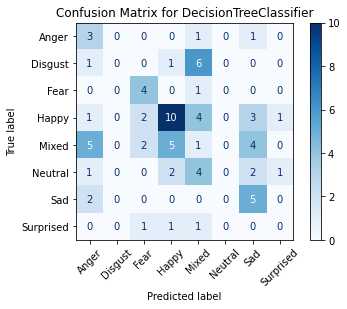

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.30      0.60      0.40         5
     Disgust       0.00      0.00      0.00         8
        Fear       0.44      0.80      0.57         5
       Happy       0.45      0.48      0.47        21
       Mixed       0.06      0.06      0.06        17
     Neutral       0.00      0.00      0.00        10
         Sad       0.33      0.71      0.45         7
   Surprised       0.00      0.00      0.00         3

    accuracy                           0.30        76
   macro avg       0.20      0.33      0.24        76
weighted avg       0.22      0.30      0.25        76



<Figure size 720x576 with 0 Axes>

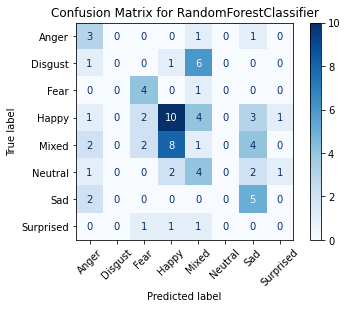

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         8
        Fear       0.40      0.40      0.40         5
       Happy       0.37      0.62      0.46        21
       Mixed       0.06      0.06      0.06        17
     Neutral       0.00      0.00      0.00        10
         Sad       0.28      0.71      0.40         7
   Surprised       0.00      0.00      0.00         3

    accuracy                           0.28        76
   macro avg       0.14      0.22      0.17        76
weighted avg       0.17      0.28      0.20        76



<Figure size 720x576 with 0 Axes>

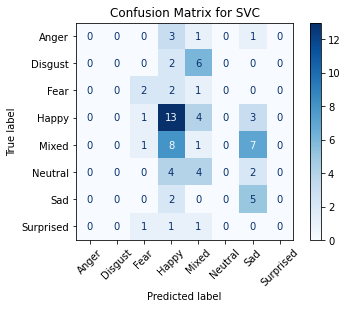

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         8
        Fear       0.13      0.80      0.23         5
       Happy       0.28      0.38      0.32        21
       Mixed       0.08      0.06      0.07        17
     Neutral       0.00      0.00      0.00        10
         Sad       0.25      0.14      0.18         7
   Surprised       0.00      0.00      0.00         3

    accuracy                           0.18        76
   macro avg       0.09      0.17      0.10        76
weighted avg       0.13      0.18      0.14        76



<Figure size 720x576 with 0 Axes>

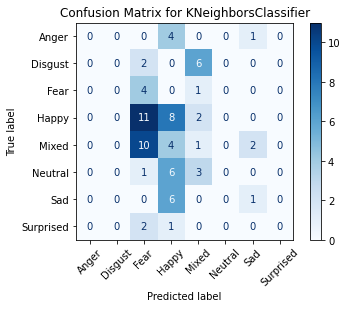

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       0.38      0.60      0.46         5
     Disgust       0.00      0.00      0.00         8
        Fear       0.44      0.80      0.57         5
       Happy       0.38      0.38      0.38        21
       Mixed       0.05      0.06      0.05        17
     Neutral       0.00      0.00      0.00        10
         Sad       0.33      0.71      0.45         7
   Surprised       0.00      0.00      0.00         3

    accuracy                           0.28        76
   macro avg       0.20      0.32      0.24        76
weighted avg       0.20      0.28      0.23        76



<Figure size 720x576 with 0 Axes>

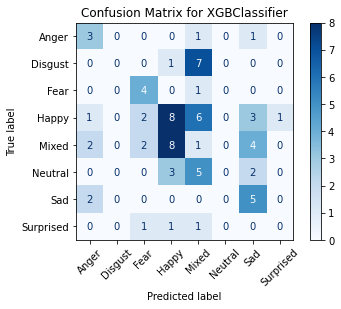

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.568182          0.302632   
 1  RandomForestClassifier           0.568182          0.302632   
 2                     SVC           0.482955          0.276316   
 3    KNeighborsClassifier           0.357955          0.184211   
 4           XGBClassifier           0.551136          0.276316   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.232980        0.302632          0.252330  
 1           0.217703        0.302632          0.247077  
 2           0.166959        0.276316          0.204229  
 3           0.125230        0.184211          0.135117  
 4           0.200043        0.276316          0.226559  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [155]:
summary_gsr_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_gsr_fft

### Statistical features (PCA) with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


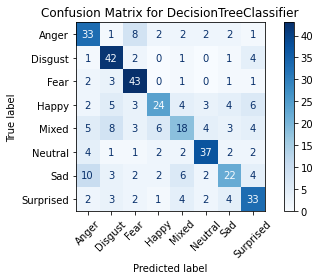

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


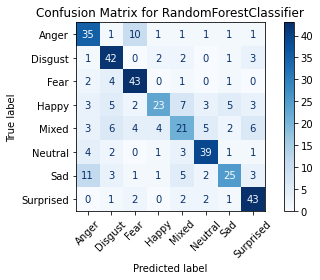

Cross-validating SVC...
Plotting confusion matrix for SVC...


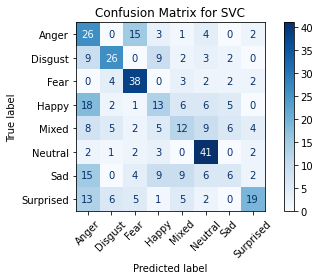

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


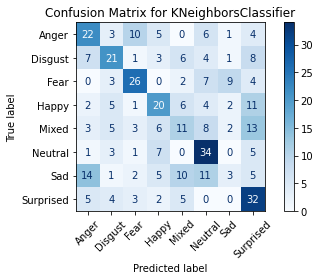

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


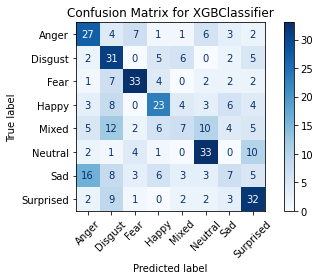

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.664216,0.663014,0.664216,0.654241
0,DecisionTreeClassifier,0.617647,0.611750,0.617647,0.607491
4,XGBClassifier,0.473039,0.453532,0.473039,0.452098
2,SVC,0.443627,0.440270,0.443627,0.424408
3,KNeighborsClassifier,0.414216,0.391913,0.414216,0.393140


In [154]:
summary_pca_gsr_stats = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_pca_gsr_stats

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


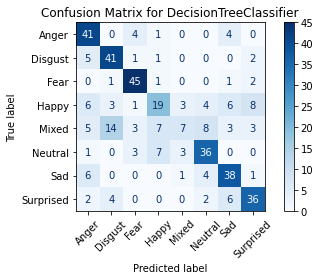

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


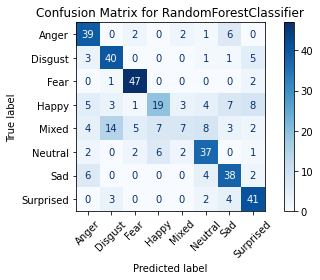

Cross-validating SVC...
Plotting confusion matrix for SVC...


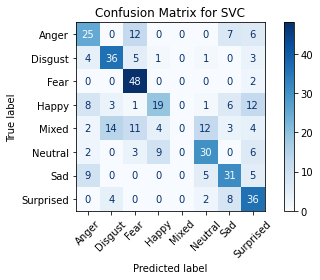

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


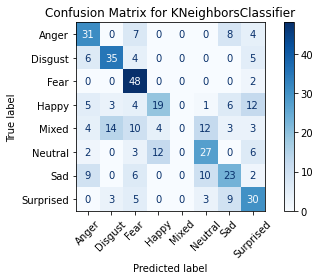

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


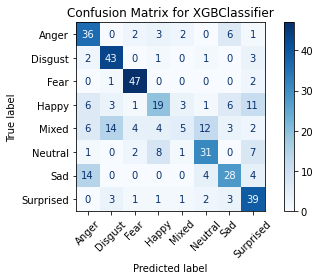

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.6700,0.650048,0.6700,0.640570
0,DecisionTreeClassifier,0.6575,0.637926,0.6575,0.629523
4,XGBClassifier,0.6200,0.597060,0.6200,0.589348
2,SVC,0.5625,0.493212,0.5625,0.516796
3,KNeighborsClassifier,0.5325,0.465297,0.5325,0.488641


In [156]:
summary_smote_gsr_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_gsr_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.40      0.31         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.62      0.83      0.71         6
       Happy       0.52      0.70      0.60        20
       Mixed       0.25      0.12      0.17        16
     Neutral       0.33      0.18      0.24        11
         Sad       0.33      0.25      0.29         4
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.45        76
   macro avg       0.41      0.43      0.40        76
weighted avg       0.41      0.45      0.41        76



<Figure size 720x576 with 0 Axes>

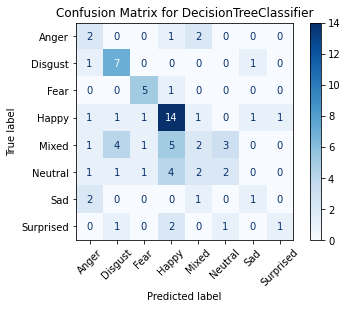

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.40      0.31         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.62      0.83      0.71         6
       Happy       0.52      0.55      0.54        20
       Mixed       0.25      0.12      0.17        16
     Neutral       0.33      0.18      0.24        11
         Sad       0.11      0.25      0.15         4
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.41        76
   macro avg       0.39      0.41      0.38        76
weighted avg       0.40      0.41      0.39        76



<Figure size 720x576 with 0 Axes>

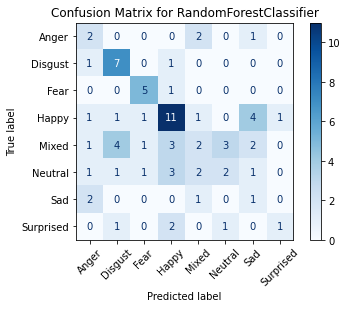

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.33      0.40      0.36         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.60      0.50      0.55         6
       Happy       0.47      0.75      0.58        20
       Mixed       0.31      0.62      0.42        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.39        76
   macro avg       0.21      0.28      0.24        76
weighted avg       0.26      0.39      0.31        76



<Figure size 720x576 with 0 Axes>

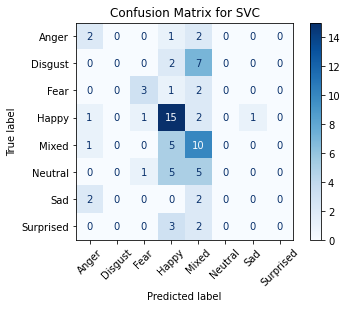

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.25      1.00      0.40         6
       Happy       0.28      0.40      0.33        20
       Mixed       0.25      0.12      0.17        16
     Neutral       0.00      0.00      0.00        11
         Sad       1.00      0.25      0.40         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.32        76
   macro avg       0.28      0.32      0.24        76
weighted avg       0.26      0.32      0.25        76



<Figure size 720x576 with 0 Axes>

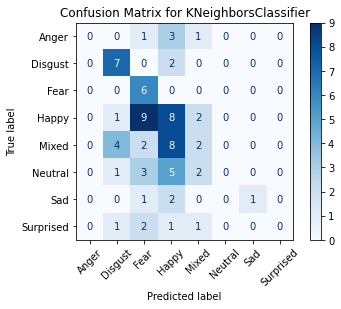

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       0.33      0.40      0.36         5
     Disgust       0.50      0.11      0.18         9
        Fear       0.62      0.83      0.71         6
       Happy       0.54      0.75      0.63        20
       Mixed       0.37      0.69      0.48        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.50      0.25      0.33         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.46        76
   macro avg       0.36      0.38      0.34        76
weighted avg       0.37      0.46      0.38        76



<Figure size 720x576 with 0 Axes>

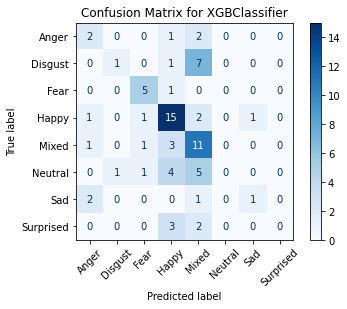

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.551136          0.447368   
 1  RandomForestClassifier           0.551136          0.407895   
 2                     SVC           0.465909          0.394737   
 3    KNeighborsClassifier           0.352273          0.315789   
 4           XGBClassifier           0.482955          0.460526   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.412768        0.447368          0.408469  
 1           0.402464        0.407895          0.385961  
 2           0.258443        0.394737          0.306527  
 3           0.256806        0.315789          0.245731  
 4           0.374969        0.460526          0.384550  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [157]:
summary_gsr_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_gsr_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


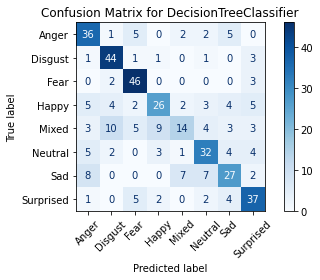

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


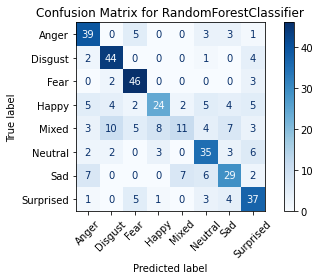

Cross-validating SVC...
Plotting confusion matrix for SVC...


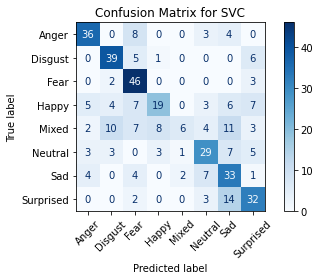

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


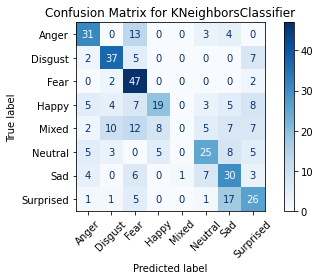

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


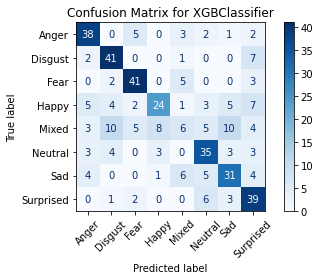

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.649510,0.639764,0.649510,0.629947
0,DecisionTreeClassifier,0.642157,0.631373,0.642157,0.627373
4,XGBClassifier,0.625000,0.601521,0.625000,0.604087
2,SVC,0.588235,0.605938,0.588235,0.561997
3,KNeighborsClassifier,0.526961,0.474575,0.526961,0.486987


In [158]:
summary_smote_gsr_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_gsr_wt

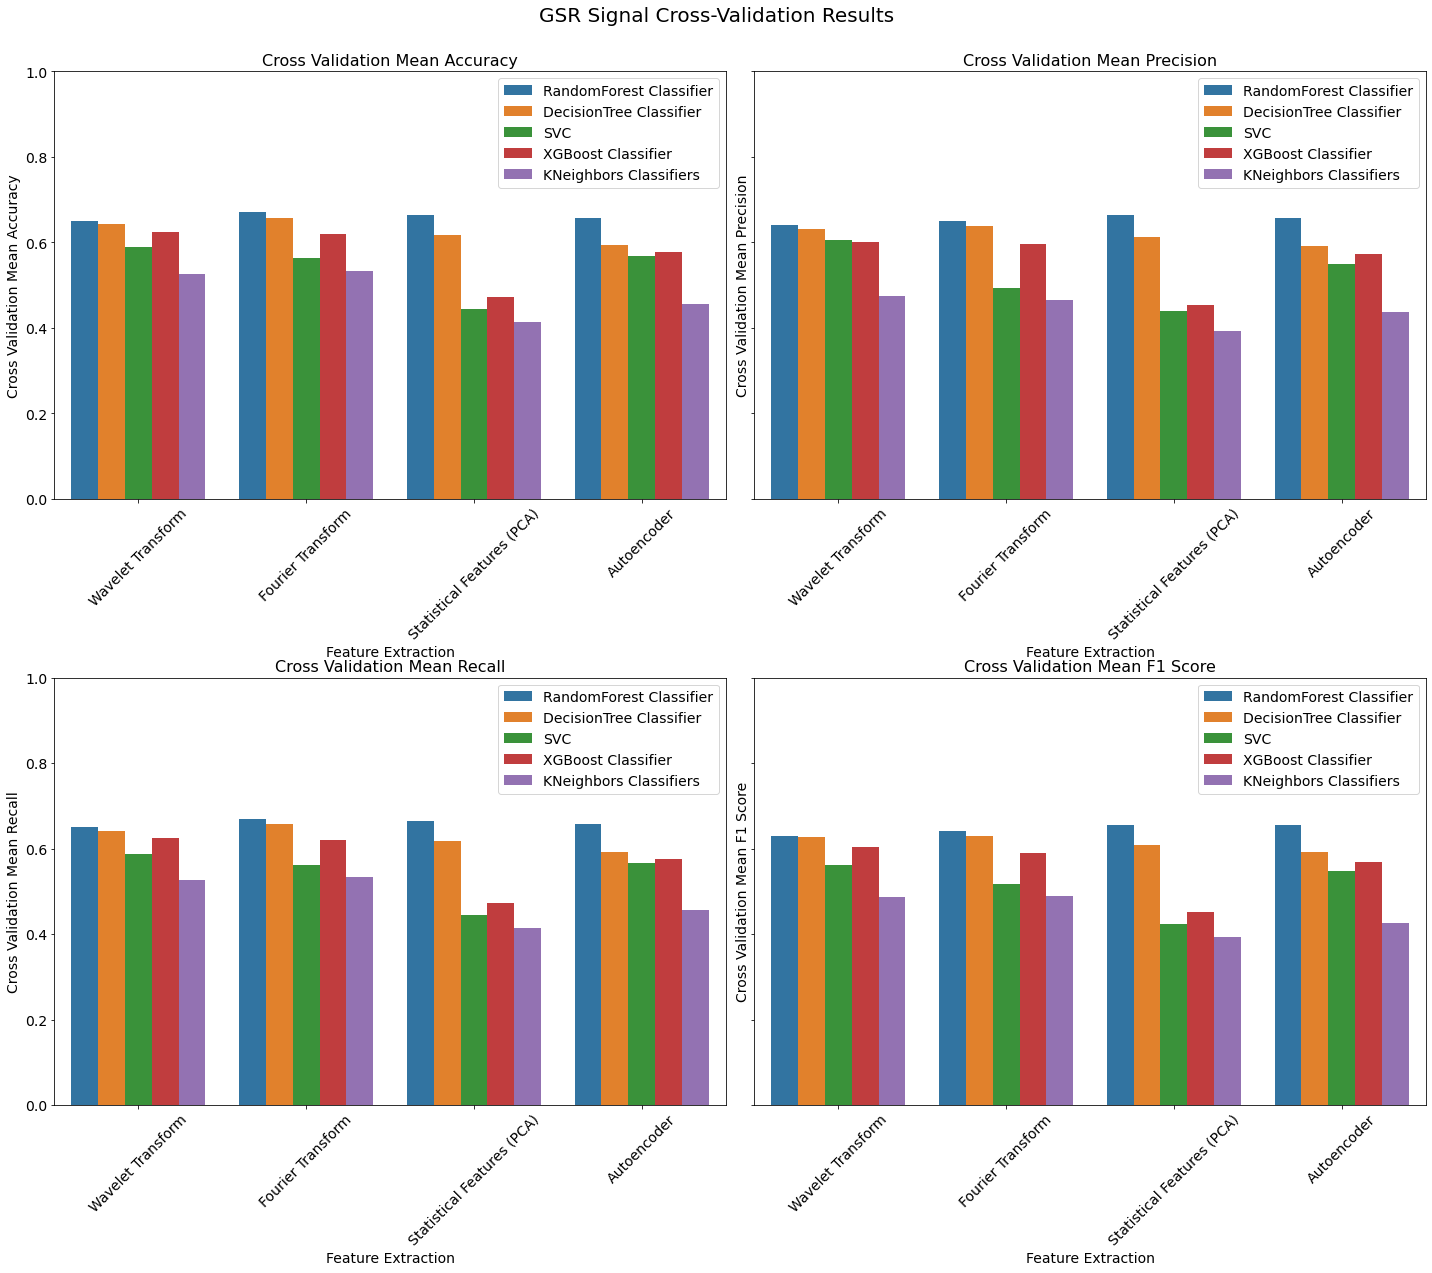

In [243]:
# GSR Results data

data_gsr = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.649510, 0.642157, 0.588235, 0.625000, 0.526961,
        0.6700, 0.6575, 0.5625, 0.6200, 0.5325,
        0.664216, 0.617647, 0.443627, 0.473039, 0.414216,
        0.657407, 0.592593, 0.567130, 0.576389, 0.456019
    ],
    "Cross Validation Mean Precision": [
        0.639764, 0.631373, 0.605938, 0.601521, 0.474575,
        0.650048, 0.637926, 0.493212, 0.597060, 0.465297,
        0.663014, 0.611750, 0.440270, 0.453532, 0.391913,
        0.656722, 0.591209, 0.549774, 0.573725, 0.436399
    ],
    "Cross Validation Mean Recall": [
        0.649510, 0.642157, 0.588235, 0.625000, 0.526961,
        0.6700, 0.6575, 0.5625, 0.6200, 0.5325,
        0.664216, 0.617647, 0.443627, 0.473039, 0.414216,
        0.657407, 0.592593, 0.567130, 0.576389, 0.456019
    ],
    "Cross Validation Mean F1 Score": [
        0.629947, 0.627373, 0.561997, 0.604087, 0.486987,
        0.640570, 0.629523, 0.516796, 0.589348, 0.488641,
        0.654241, 0.607491, 0.424408, 0.452098, 0.393140,
        0.654314, 0.591179, 0.548308, 0.567832, 0.427078
    ]
}

plot_cross_validation_results(data_gsr, 'results_comparison_gsr.png', "GSR Signal Cross-Validation Results")

## COMBINE ECG AND GSR SIGNALS  AND EXTRACT FEATURES

#### Concatinating ECG AND GSR signals dataframes

In [159]:
ecg_gsr = pd.concat([ecg_signals, gsr_signals], axis = 1)

In [160]:
ecg_gsr_signals = ecg_gsr.copy()
ecg_gsr_signals.head(2)

,feature_ecg,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.1681,0.034243
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.1681,0.034243


In [161]:
ecg_gsr_signals.columns

Index(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name',
       'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level',
       'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'emotion_ecg', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'meanrr_ecg', 'medianrr_ecg',
       'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg',
       'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg', 'skew_ecg', 'kurt_ecg',
       'csi_ecg', 'modifiedcvi_ecg', 'feature_gsr', 'Participant ID',
       'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level',
       'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger',
       'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'emotion_gsr',
       'Valence', 'Arousal', 'Four label', 'Annotation', 'Target Emotion',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gs

In [162]:
ecg_gsr_signals = ecg_gsr_signals.drop(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'feature_gsr', 'Participant ID', 'Session ID',
       'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level',
       'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral',
       'Disgust', 'Surprised', 'Familiarity Score', 'Valence',
       'Arousal', 'Four label', 'Annotation', 'Target Emotion'], axis = 1)

In [168]:
print(ecg_gsr_signals.columns)

Index(['emotion_ecg', 'meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg',
       'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg',
       'avrr_ecg', 'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg',
       'emotion_gsr', 'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr',
       'sdrr_rmssd_gsr', 'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr',
       'avrr_gsr', 'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')


In [169]:
ecg_gsr_signals = ecg_gsr_signals.drop('emotion_ecg', axis = 1)

In [170]:
ecg_gsr_signals.head()

,meanrr_ecg,medianrr_ecg,sdrr_ecg,rmssd_ecg,sdrr_rmssd_ecg,hr_ecg,NNx_ecg,pNNx_ecg,sd1_ecg,sd2_ecg,...,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,...,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,...,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,...,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066


In [171]:
ecg_gsr_signals.columns

Index(['meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg',
       'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg',
       'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg', 'emotion_gsr',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr', 'avrr_gsr',
       'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [172]:
ecg_gsr_signals.rename(columns = {'emotion_gsr':'emotion'}, inplace = True)
ecg_gsr_signals.head()

,meanrr_ecg,medianrr_ecg,sdrr_ecg,rmssd_ecg,sdrr_rmssd_ecg,hr_ecg,NNx_ecg,pNNx_ecg,sd1_ecg,sd2_ecg,...,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,...,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,...,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,...,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066


In [175]:
ecg_gsr_signals.columns

Index(['meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg',
       'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg',
       'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg', 'emotion',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr', 'avrr_gsr',
       'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [176]:
X = ecg_gsr_signals.drop(['emotion'], axis=1)
y = ecg_gsr_signals['emotion']

In [177]:
X.head()

,meanrr_ecg,medianrr_ecg,sdrr_ecg,rmssd_ecg,sdrr_rmssd_ecg,hr_ecg,NNx_ecg,pNNx_ecg,sd1_ecg,sd2_ecg,...,hr_gsr,NNx_gsr,pNNx_gsr,sd1_gsr,sd2_gsr,avrr_gsr,skew_gsr,kurt_gsr,csi_gsr,modifiedcvi_gsr
0,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
1,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,...,288.973793,0,0.0,0.050926,0.302952,-18.766022,3.058683,12.166933,0.168100,0.034243
2,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,...,294.650732,1,25.0,0.051486,0.308310,-18.537975,3.158817,12.848869,0.166994,0.034392
3,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,...,317.593251,0,0.0,0.045385,0.286779,-18.559574,2.862825,11.344312,0.158256,0.028730
4,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,...,273.960919,0,0.0,0.044048,0.276516,-18.488177,2.842292,11.033996,0.159295,0.028066


In [178]:
y[:10]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
5     Disgust
6       Anger
7       Happy
8         Sad
9     Neutral
Name: emotion, dtype: object

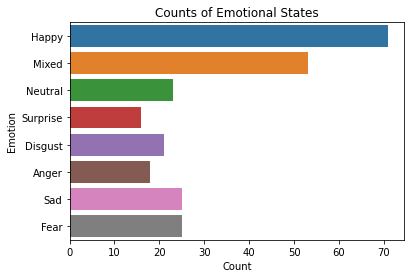

In [179]:
sns.countplot(y='emotion', data=ecg_gsr_signals)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

In [180]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [181]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [183]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [184]:
arr_shape

1000

#### Applying SMOTE to the training data

In [185]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [186]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [187]:
len(y_smote)

432

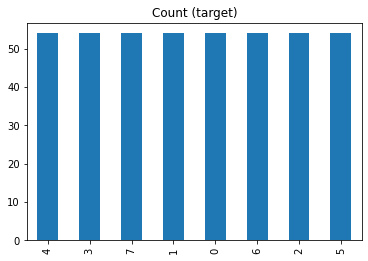

In [188]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER 

In [189]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# input_layer = Input(shape=(X_train_encoder[1],))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [190]:
autoencoder_smote.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_10 (Dense)            (None, 128)               3968      
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 32)                2080

In [191]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [192]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 [==============================] - 4s 27ms/step - loss: 0.9406 - val_loss: 1.1560
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.7533 - val_loss: 1.1001
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 0.6669 - val_loss: 1.0316
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 0.6049 - val_loss: 0.9688
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5716 - val_loss: 0.9069
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5495 - val_loss: 0.8493
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5245 - val_loss: 0.8025
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5097 - val_loss: 0.7600
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4989 - val_loss: 0.7238
Epoch 10/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4935 - val_loss: 0.6939
Epoc

Epoch 83/100
14/14 [==============================] - 0s 11ms/step - loss: 0.4257 - val_loss: 0.5379
Epoch 84/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4275 - val_loss: 0.5374
Epoch 85/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4269 - val_loss: 0.5371
Epoch 86/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4264 - val_loss: 0.5374
Epoch 87/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4274 - val_loss: 0.5365
Epoch 88/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4277 - val_loss: 0.5363
Epoch 89/100
14/14 [==============================] - 0s 10ms/step - loss: 0.4278 - val_loss: 0.5365
Epoch 90/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4267 - val_loss: 0.5366
Epoch 91/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4267 - val_loss: 0.5363
Epoch 92/100
14/14 [==============================] - 0s 10ms/step - loss: 0.4270 - val_loss: 0.53

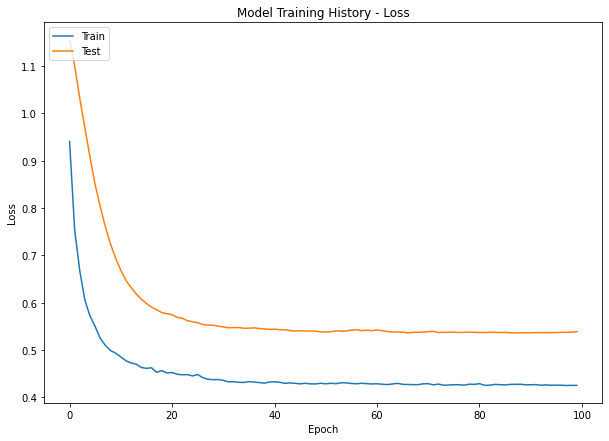

In [193]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [194]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


### PCA ON STATISTICAL FEATURES

In [195]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [196]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [197]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [198]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [199]:
signals = ecg_gsr.copy()

In [200]:
signals.rename(columns = {'emotion_ecg':'emotion'}, inplace = True)
signals = signals[['feature_ecg', 'feature_gsr', 'emotion']]
signals.head()

,feature_ecg,feature_gsr,emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...","[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",Happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...","[246.32, 246.41, 246.59, 246.52, 246.58, 246.8...",Happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...","[631.12, 630.95, 631.12, 630.4, 631.03, 631.04...",Mixed
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...","[357.72, 357.43, 357.32, 357.24, 356.95, 357.0...",Neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...","[438.26, 437.83, 438.21, 438.14, 438.2, 438.15...",Surprise


In [201]:
def apply_fourier_transform_signals(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [202]:
# Apply Fourier Transform to each row in the DataFrame
feature_ecg_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_gsr']])

In [203]:
feature_ecg_fft

array([[ 1.87660220e+04,  8.58203891e+00,  4.16380649e+00, ...,
        -6.33034538e-01, -1.39726141e-01,  1.15922184e+00],
       [ 1.87660220e+04,  8.58203891e+00,  4.16380649e+00, ...,
        -6.33034538e-01, -1.39726141e-01,  1.15922184e+00],
       [ 1.85379750e+04,  2.00011387e+01,  1.54785637e+01, ...,
         1.03165047e+00,  4.67389175e-01,  2.88622134e+00],
       ...,
       [ 3.68047360e+03,  2.13946153e+01,  1.22577229e+01, ...,
         2.12068546e+00,  2.46035008e+00,  2.54937394e+00],
       [ 3.97659840e+03,  9.70004174e+00,  3.83193550e+00, ...,
         1.96020451e+00,  2.36818915e+00,  2.51551692e+00],
       [ 2.03688790e+04,  4.25541555e+00,  8.91701092e+00, ...,
        -1.90028530e+00, -1.91814441e+00, -2.60466539e+00]])

In [204]:
feature_gsr_fft

array([[ 2.42955750e+05,  2.10652499e+03,  1.32593768e+03, ...,
        -2.69487877e+00,  3.10775278e+00,  2.60041957e+00],
       [ 2.42955750e+05,  2.10652499e+03,  1.32593768e+03, ...,
        -2.69487877e+00,  3.10775278e+00,  2.60041957e+00],
       [ 6.38951970e+05,  2.24729573e+03,  8.68265321e+02, ...,
         1.61824241e+00,  1.62410599e+00,  1.65498971e+00],
       ...,
       [ 3.93612210e+05,  2.10273789e+03,  8.81811430e+02, ...,
        -1.95075242e+00, -1.44317707e+00, -1.97706791e+00],
       [ 7.09014180e+05,  1.37725621e+03,  7.25252043e+02, ...,
         9.52677268e-01,  2.35163861e-01,  1.48331573e+00],
       [ 3.78989490e+05,  1.15497685e+04,  4.15024325e+03, ...,
        -1.45396091e+00, -1.47113495e+00, -1.34219340e+00]])

In [205]:
# Apply Fourier Transform to each row
feature_ecg_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_gsr']])

# Convert to DataFrame
feature_ecg_fft_df = pd.DataFrame(feature_ecg_fft, columns=[f'feature_ecg_fft_{i}' for i in range(feature_ecg_fft.shape[1])])
feature_gsr_fft_df = pd.DataFrame(feature_gsr_fft, columns=[f'feature_gsr_fft_{i}' for i in range(feature_gsr_fft.shape[1])])

In [206]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals.drop(['feature_ecg', 'feature_gsr', 'emotion'], axis=1),
               feature_ecg_fft_df, feature_gsr_fft_df], axis=1)

In [207]:
X.columns

Index(['feature_ecg_fft_0', 'feature_ecg_fft_1', 'feature_ecg_fft_2',
       'feature_ecg_fft_3', 'feature_ecg_fft_4', 'feature_ecg_fft_5',
       'feature_ecg_fft_6', 'feature_ecg_fft_7', 'feature_ecg_fft_8',
       'feature_ecg_fft_9', 'feature_ecg_fft_10', 'feature_ecg_fft_11',
       'feature_ecg_fft_12', 'feature_ecg_fft_13', 'feature_ecg_fft_14',
       'feature_ecg_fft_15', 'feature_ecg_fft_16', 'feature_ecg_fft_17',
       'feature_ecg_fft_18', 'feature_ecg_fft_19', 'feature_gsr_fft_0',
       'feature_gsr_fft_1', 'feature_gsr_fft_2', 'feature_gsr_fft_3',
       'feature_gsr_fft_4', 'feature_gsr_fft_5', 'feature_gsr_fft_6',
       'feature_gsr_fft_7', 'feature_gsr_fft_8', 'feature_gsr_fft_9',
       'feature_gsr_fft_10', 'feature_gsr_fft_11', 'feature_gsr_fft_12',
       'feature_gsr_fft_13', 'feature_gsr_fft_14', 'feature_gsr_fft_15',
       'feature_gsr_fft_16', 'feature_gsr_fft_17', 'feature_gsr_fft_18',
       'feature_gsr_fft_19'],
      dtype='object')

In [208]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [209]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [210]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Applying SMOTE

In [211]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

### WAVELET TRANSFORM

In [212]:
def apply_wavelet_transform_signals(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [215]:
# Apply Wavelet Transform to each row in the DataFrame
feature_ecg_wavelet = np.array([apply_wavelet_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_wavelet = np.array([apply_wavelet_transform_signals(arr) for arr in signals['feature_gsr']])

In [216]:
# Convert to DataFrame
feature_ecg_wavelet_df = pd.DataFrame(feature_ecg_wavelet, columns=[f'feature_ecg_wavelet_{i}' for i in range(feature_ecg_wavelet.shape[1])])
feature_gsr_wavelet_df = pd.DataFrame(feature_gsr_wavelet, columns=[f'feature_gsr_wavelet_{i}' for i in range(feature_gsr_wavelet.shape[1])])

In [218]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals.drop(['feature_ecg', 'feature_gsr', 'emotion'], axis=1),
               feature_ecg_wavelet_df, feature_gsr_wavelet_df], axis=1)

In [219]:
X.columns

Index(['feature_ecg_wavelet_0', 'feature_ecg_wavelet_1',
       'feature_ecg_wavelet_2', 'feature_ecg_wavelet_3',
       'feature_ecg_wavelet_4', 'feature_ecg_wavelet_5',
       'feature_ecg_wavelet_6', 'feature_ecg_wavelet_7',
       'feature_ecg_wavelet_8', 'feature_ecg_wavelet_9',
       'feature_ecg_wavelet_10', 'feature_ecg_wavelet_11',
       'feature_ecg_wavelet_12', 'feature_ecg_wavelet_13',
       'feature_ecg_wavelet_14', 'feature_ecg_wavelet_15',
       'feature_ecg_wavelet_16', 'feature_ecg_wavelet_17',
       'feature_ecg_wavelet_18', 'feature_ecg_wavelet_19',
       'feature_gsr_wavelet_0', 'feature_gsr_wavelet_1',
       'feature_gsr_wavelet_2', 'feature_gsr_wavelet_3',
       'feature_gsr_wavelet_4', 'feature_gsr_wavelet_5',
       'feature_gsr_wavelet_6', 'feature_gsr_wavelet_7',
       'feature_gsr_wavelet_8', 'feature_gsr_wavelet_9',
       'feature_gsr_wavelet_10', 'feature_gsr_wavelet_11',
       'feature_gsr_wavelet_12', 'feature_gsr_wavelet_13',
       'feature_g

In [220]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [221]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Applying SMOTE to training data

In [222]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

#### Displaying the results

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.20      0.20      0.20         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.50      0.50      0.50         6
       Happy       0.39      0.45      0.42        20
       Mixed       0.29      0.25      0.27        16
     Neutral       0.43      0.27      0.33        11
         Sad       0.10      0.25      0.14         4
   Surprised       0.29      0.40      0.33         5

    accuracy                           0.30        76
   macro avg       0.27      0.29      0.27        76
weighted avg       0.30      0.30      0.30        76



<Figure size 720x576 with 0 Axes>

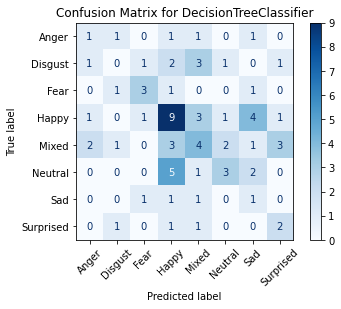

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.33      0.33      0.33         6
       Happy       0.38      0.55      0.45        20
       Mixed       0.29      0.31      0.30        16
     Neutral       0.50      0.27      0.35        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.32        76
   macro avg       0.27      0.26      0.26        76
weighted avg       0.30      0.32      0.30        76



<Figure size 720x576 with 0 Axes>

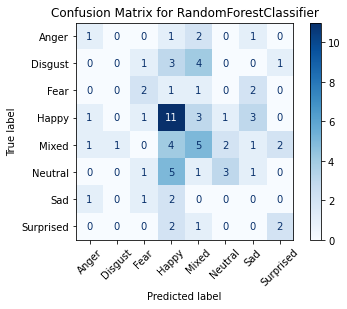

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.60      0.36        20
       Mixed       0.22      0.31      0.26        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.11      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 720x576 with 0 Axes>

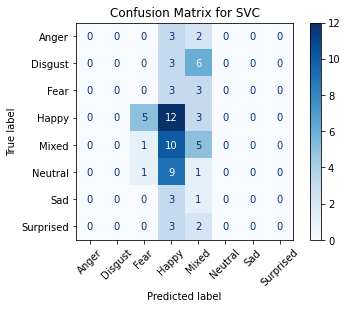

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.30      0.65      0.41        20
       Mixed       0.14      0.19      0.16        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.20      0.17      0.14        76
weighted avg       0.19      0.25      0.18        76



<Figure size 720x576 with 0 Axes>

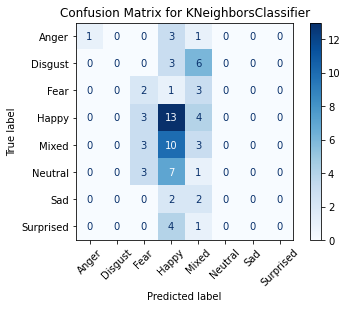

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.25      0.11      0.15         9
        Fear       0.67      0.33      0.44         6
       Happy       0.41      0.80      0.54        20
       Mixed       0.32      0.50      0.39        16
     Neutral       1.00      0.09      0.17        11
         Sad       0.33      0.25      0.29         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.39        76
   macro avg       0.50      0.29      0.29        76
weighted avg       0.49      0.39      0.34        76



<Figure size 720x576 with 0 Axes>

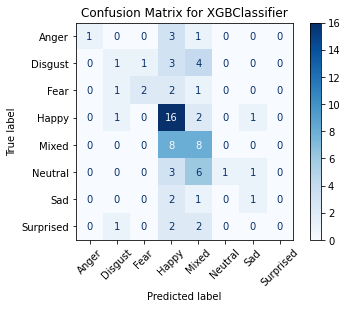

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.778409          0.302632   
 1  RandomForestClassifier           0.784091          0.315789   
 2                     SVC           0.369318          0.223684   
 3    KNeighborsClassifier           0.357955          0.250000   
 4           XGBClassifier           0.500000          0.394737   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.301847        0.302632          0.296625  
 1           0.303185        0.315789          0.300283  
 2           0.114416        0.223684          0.149675  
 3           0.189778        0.250000          0.183250  
 4           0.485638        0.394737          0.339283  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [223]:
summary_combined_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_combined_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


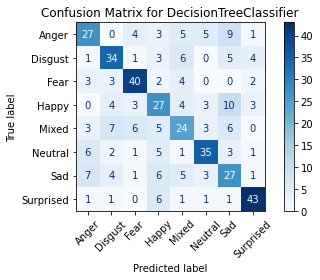

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


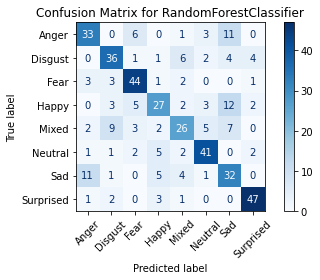

Cross-validating SVC...
Plotting confusion matrix for SVC...


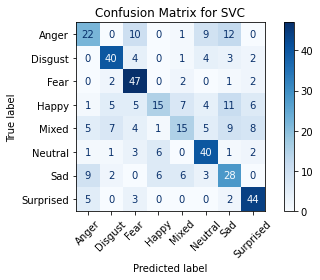

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


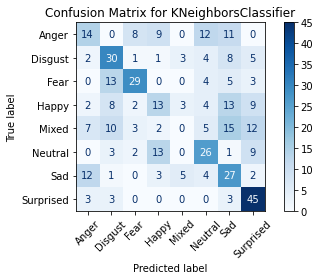

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


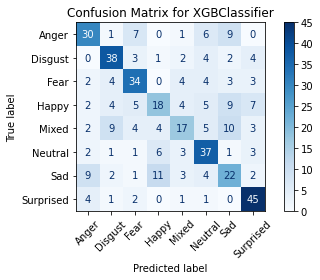

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.662037,0.662131,0.662037,0.659518
0,DecisionTreeClassifier,0.594907,0.596637,0.594907,0.595024
2,SVC,0.581019,0.569633,0.581019,0.561617
4,XGBClassifier,0.557870,0.547360,0.557870,0.547022
3,KNeighborsClassifier,0.425926,0.381011,0.425926,0.393880


In [224]:
summary_smote_combined_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_combined_autoencoder

### Statistical features with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


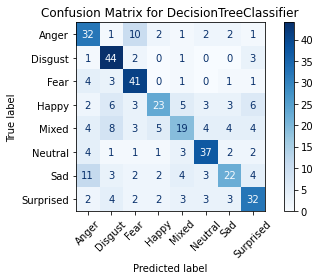

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


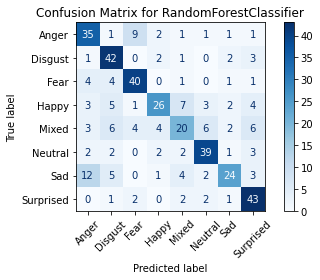

Cross-validating SVC...
Plotting confusion matrix for SVC...


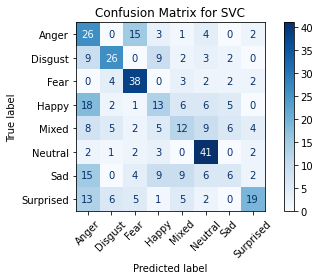

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


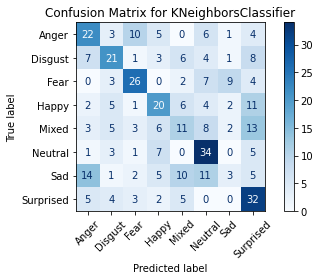

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


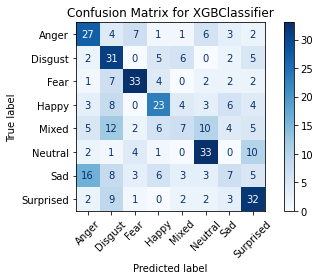

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.659314,0.659576,0.659314,0.649890
0,DecisionTreeClassifier,0.612745,0.610387,0.612745,0.602178
4,XGBClassifier,0.473039,0.453532,0.473039,0.452098
2,SVC,0.443627,0.440270,0.443627,0.424408
3,KNeighborsClassifier,0.414216,0.391913,0.414216,0.393140


In [225]:
summary_smote_combined_pca = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_smote_combined_pca

### Fourier transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.67      0.50      0.57         4
     Disgust       0.38      0.83      0.53         6
        Fear       0.44      0.80      0.57         5
       Happy       0.30      0.29      0.30        24
       Mixed       0.15      0.10      0.12        20
     Neutral       0.00      0.00      0.00         7
         Sad       0.12      0.25      0.17         4
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.28        76
   macro avg       0.26      0.35      0.28        76
weighted avg       0.24      0.28      0.24        76



<Figure size 720x576 with 0 Axes>

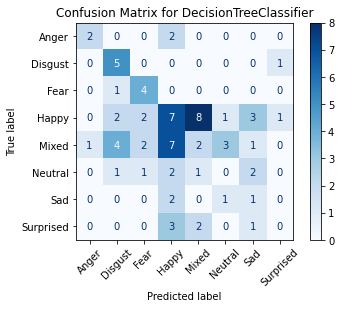

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.33      0.67      0.44         6
        Fear       0.44      0.80      0.57         5
       Happy       0.44      0.50      0.47        24
       Mixed       0.33      0.15      0.21        20
     Neutral       0.00      0.00      0.00         7
         Sad       0.23      0.75      0.35         4
   Surprised       1.00      0.17      0.29         6

    accuracy                           0.36        76
   macro avg       0.35      0.38      0.29        76
weighted avg       0.37      0.36      0.32        76



<Figure size 720x576 with 0 Axes>

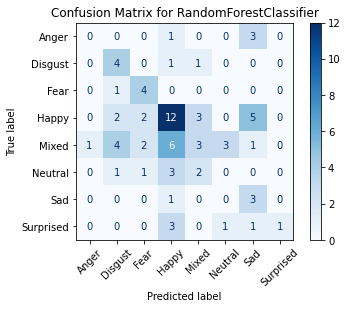

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.50      0.50      0.50         4
     Disgust       0.33      0.67      0.44         6
        Fear       0.40      0.40      0.40         5
       Happy       0.46      0.54      0.50        24
       Mixed       0.21      0.20      0.21        20
     Neutral       0.25      0.14      0.18         7
         Sad       0.50      0.50      0.50         4
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.37        76
   macro avg       0.33      0.37      0.34        76
weighted avg       0.33      0.37      0.34        76



<Figure size 720x576 with 0 Axes>

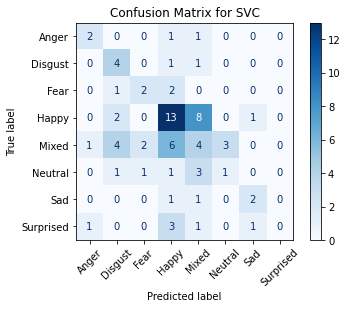

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.67      0.50      0.57         4
     Disgust       0.29      0.33      0.31         6
        Fear       0.17      0.60      0.26         5
       Happy       0.31      0.42      0.36        24
       Mixed       0.36      0.25      0.29        20
     Neutral       0.00      0.00      0.00         7
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.29        76
   macro avg       0.22      0.26      0.22        76
weighted avg       0.26      0.29      0.26        76



<Figure size 720x576 with 0 Axes>

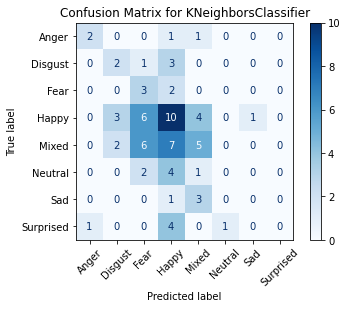

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.33      0.83      0.48         6
        Fear       0.29      0.40      0.33         5
       Happy       0.39      0.38      0.38        24
       Mixed       0.27      0.15      0.19        20
     Neutral       0.20      0.14      0.17         7
         Sad       0.14      0.50      0.22         4
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.29        76
   macro avg       0.20      0.30      0.22        76
weighted avg       0.27      0.29      0.26        76



<Figure size 720x576 with 0 Axes>

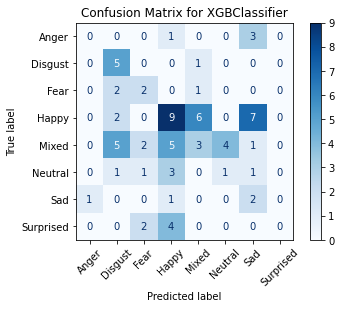

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.852273          0.276316   
 1  RandomForestClassifier           0.852273          0.355263   
 2                     SVC           0.687500          0.368421   
 3    KNeighborsClassifier           0.414773          0.289474   
 4           XGBClassifier           0.670455          0.289474   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.237866        0.276316          0.243955  
 1           0.374719        0.355263          0.316867  
 2           0.330308        0.368421          0.342657  
 3           0.261278        0.289474          0.261710  
 4           0.266393        0.289474          0.258445  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [226]:
summary_combined_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_combined_fft

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


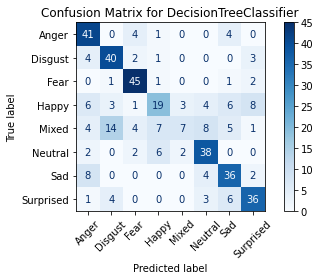

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


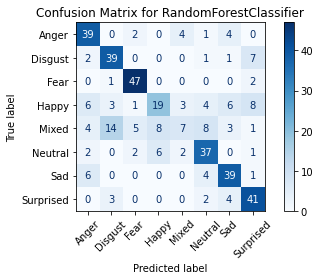

Cross-validating SVC...
Plotting confusion matrix for SVC...


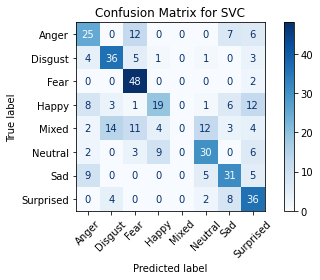

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


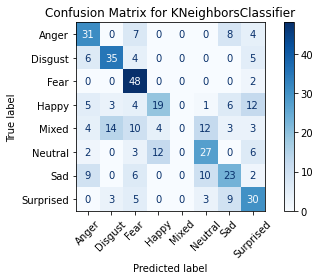

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


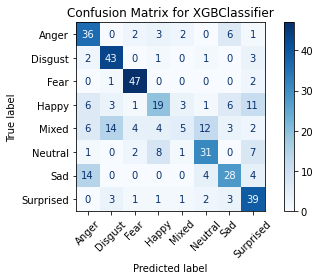

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
1,RandomForestClassifier,0.6700,0.644288,0.6700,0.641555
0,DecisionTreeClassifier,0.6550,0.643511,0.6550,0.626276
4,XGBClassifier,0.6200,0.597060,0.6200,0.589348
2,SVC,0.5625,0.493212,0.5625,0.516796
3,KNeighborsClassifier,0.5325,0.465297,0.5325,0.488641


In [231]:
summary_smote_combined_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_combined_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.50      0.11      0.18         9
        Fear       0.57      0.67      0.62         6
       Happy       0.25      0.30      0.27        20
       Mixed       0.23      0.31      0.26        16
     Neutral       0.25      0.09      0.13        11
         Sad       0.17      0.25      0.20         4
   Surprised       0.29      0.40      0.33         5

    accuracy                           0.28        76
   macro avg       0.31      0.29      0.28        76
weighted avg       0.30      0.28      0.26        76



<Figure size 720x576 with 0 Axes>

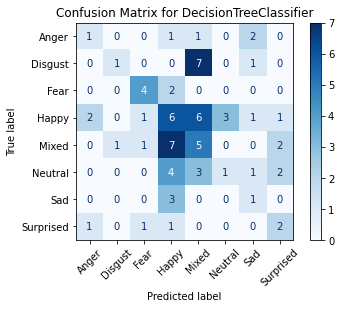

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.20      0.20      0.20         5
     Disgust       0.50      0.33      0.40         9
        Fear       0.67      0.67      0.67         6
       Happy       0.27      0.35      0.30        20
       Mixed       0.32      0.38      0.34        16
     Neutral       0.33      0.09      0.14        11
         Sad       0.33      0.50      0.40         4
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.34        76
   macro avg       0.38      0.36      0.36        76
weighted avg       0.35      0.34      0.33        76



<Figure size 720x576 with 0 Axes>

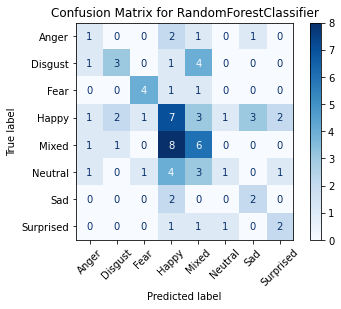

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.67      0.67      0.67         6
       Happy       0.27      0.50      0.35        20
       Mixed       0.25      0.44      0.32        16
     Neutral       0.50      0.09      0.15        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.30        76
   macro avg       0.27      0.24      0.22        76
weighted avg       0.28      0.30      0.25        76



<Figure size 720x576 with 0 Axes>

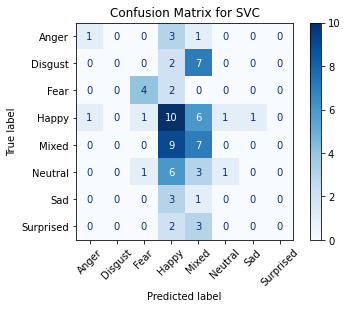

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.33      0.22      0.27         9
        Fear       0.20      0.67      0.31         6
       Happy       0.28      0.45      0.35        20
       Mixed       0.27      0.25      0.26        16
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.26        76
   macro avg       0.20      0.22      0.18        76
weighted avg       0.22      0.26      0.22        76



<Figure size 720x576 with 0 Axes>

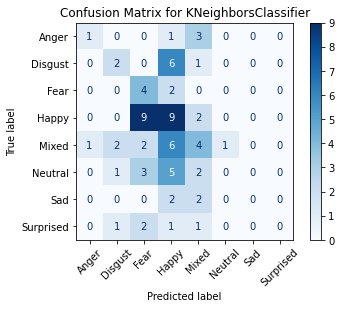

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.40      0.44         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.60      0.50      0.55         6
       Happy       0.33      0.50      0.40        20
       Mixed       0.27      0.44      0.33        16
     Neutral       0.14      0.09      0.11        11
         Sad       0.00      0.00      0.00         4
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.30        76
   macro avg       0.23      0.24      0.23        76
weighted avg       0.25      0.30      0.26        76



<Figure size 720x576 with 0 Axes>

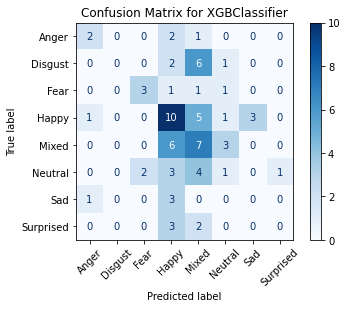

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.818182          0.276316   
 1  RandomForestClassifier           0.818182          0.342105   
 2                     SVC           0.653409          0.302632   
 3    KNeighborsClassifier           0.369318          0.263158   
 4           XGBClassifier           0.625000          0.302632   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.298160        0.276316          0.263660  
 1           0.354437        0.342105          0.333475  
 2           0.281650        0.302632          0.253018  
 3           0.218311        0.263158          0.220090  
 4           0.245339        0.302632          0.263822  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsam

In [228]:
summary_combined_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_combined_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


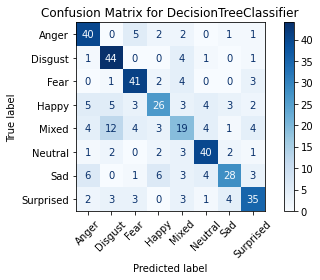

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


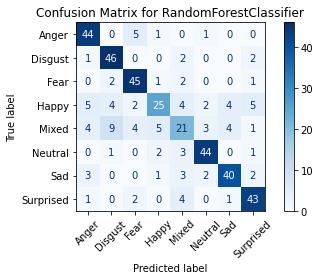

Cross-validating SVC...
Plotting confusion matrix for SVC...


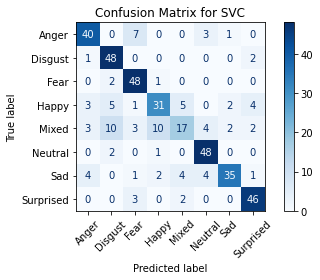

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


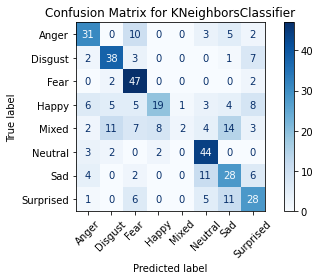

Cross-validating XGBClassifier...
Plotting confusion matrix for XGBClassifier...


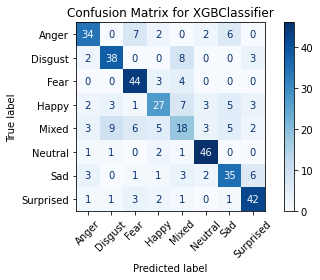

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
2,SVC,0.767157,0.760449,0.767157,0.753259
1,RandomForestClassifier,0.754902,0.746683,0.754902,0.745117
4,XGBClassifier,0.696078,0.686939,0.696078,0.688734
0,DecisionTreeClassifier,0.669118,0.663779,0.669118,0.660969
3,KNeighborsClassifier,0.580882,0.596273,0.580882,0.540718


In [229]:
summary_smote_combined_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_combined_wt

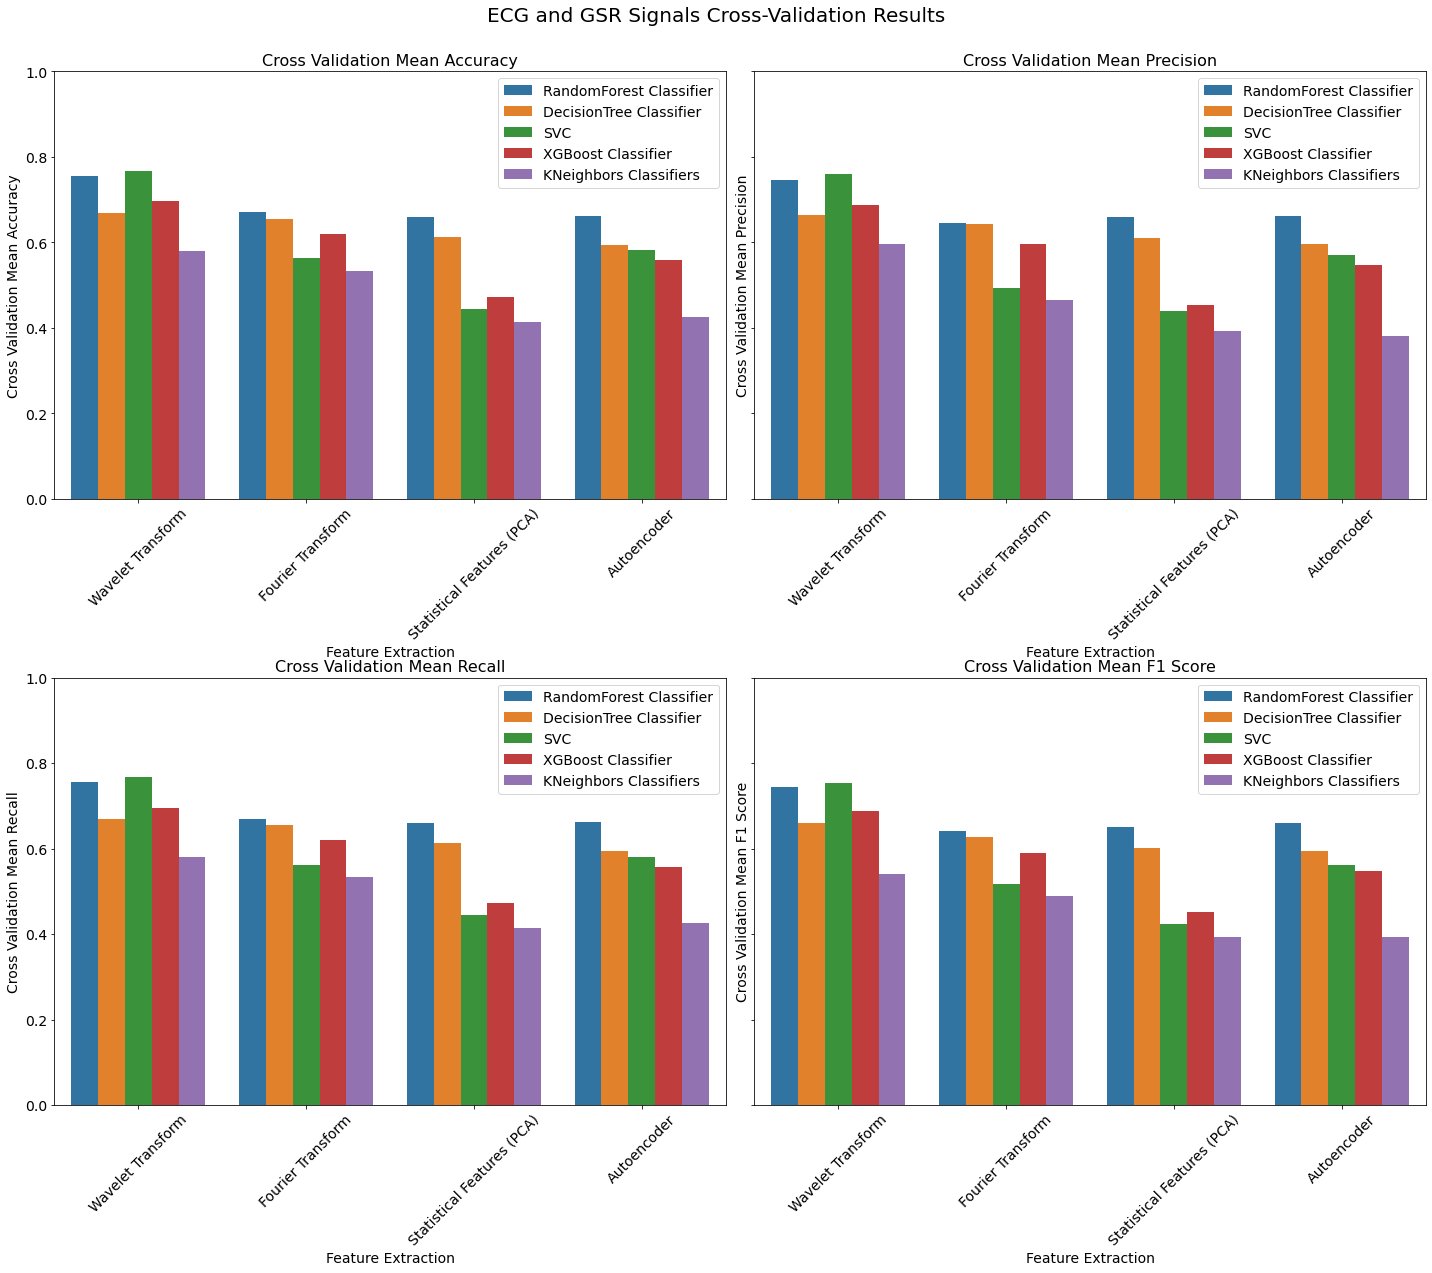

In [244]:
# Combined Results data

data_combined = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "XGBoost Classifier", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.754902, 0.669118, 0.767157, 0.696078, 0.580882,
        0.6700, 0.6550, 0.5625, 0.6200, 0.5325,
        0.659314, 0.612745, 0.443627, 0.473039, 0.414216,
        0.662037, 0.594907, 0.581019, 0.557870, 0.425926
    ],
    "Cross Validation Mean Precision": [
        0.746683, 0.663779, 0.760449, 0.686939, 0.596273,
        0.644288, 0.643511, 0.493212, 0.597060, 0.465297,
        0.659576, 0.610387, 0.440270, 0.453532, 0.391913,
        0.662131, 0.596637, 0.569633, 0.547360, 0.381011
    ],
    "Cross Validation Mean Recall": [
        0.754902, 0.669118, 0.767157, 0.696078, 0.580882,
        0.6700, 0.6550, 0.5625, 0.6200, 0.5325,
        0.659314, 0.612745, 0.443627, 0.473039, 0.414216,
        0.662037, 0.594907, 0.581019, 0.557870, 0.425926
    ],
    "Cross Validation Mean F1 Score": [
        0.745117, 0.660969, 0.753259, 0.688734, 0.540718,
        0.641555, 0.626276, 0.516796, 0.589348, 0.488641,
        0.649890, 0.602178, 0.424408, 0.452098, 0.393140,
        0.659518, 0.595024, 0.561617, 0.547022, 0.393880
    ]
}

plot_cross_validation_results(data_combined, 'results_comparison_combined.png', "ECG and GSR Signals Cross-Validation Results")